This notebook will mainly automate the CKA calculation process for multiple pairs of trials.

Most of the code will be same as `Camels_CKA_HI.ipynb`.

# Unchanged code

In [1]:
# Unchanged code
!pip install optuna==2.4.0

import tqdm
import numpy as np

import numpy as np
import optuna
from google.colab import drive
import torch
import torch.nn as nn
import sys,os
import random
from torch.utils.data import DataLoader

import shutil
import time

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')


def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros
  np.fill_diagonal(K, val=0) #this is now K_tilde
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator


  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''

  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka

def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score


# def get_all_layer_outputs_fn(model):
#   '''Builds and returns function that returns the output of every (intermediate) layer'''

#   return tf.keras.backend.function([model.layers[0].input],
#                                   [l.output for l in model.layers[1:]])

def compare_activations(modelA, modelB, data_batch):
  '''
  Calculate a pairwise comparison of hidden representations and return a matrix
  '''
  modelA.eval(); modelB.eval()

  _, intermediate_outputs_A = modelA(data_batch)
  _, intermediate_outputs_B = modelB(data_batch)

  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      print(outputA.shape, outputB.shape)
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array

# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle, worker_init_fn=seed_worker, generator=g)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        print(total_sims, splits, params_sims.shape[0])
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        print(len(indexes))
        print(indexes.shape)

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]

class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        # self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)

        self.dropout   = nn.Dropout(p=dr)
        # self.ReLU      = nn.ReLU()

        self.LeakyReLUs = []

        # We do this so that we can turn off some leaky relus according to our wish.
        self.LeakyReLU1 = nn.LeakyReLU(0.2)
        self.LeakyReLU2 = nn.LeakyReLU(0.2)
        self.LeakyReLU3 = nn.LeakyReLU(0.2)
        self.LeakyReLU4 = nn.LeakyReLU(0.2)
        self.LeakyReLU5 = nn.LeakyReLU(0.2)
        self.LeakyReLU6 = nn.LeakyReLU(0.2)
        self.LeakyReLU7 = nn.LeakyReLU(0.2)
        self.LeakyReLU8 = nn.LeakyReLU(0.2)
        self.LeakyReLU9 = nn.LeakyReLU(0.2)
        self.LeakyReLU10 = nn.LeakyReLU(0.2)
        self.LeakyReLU11 = nn.LeakyReLU(0.2)
        self.LeakyReLU12 = nn.LeakyReLU(0.2)
        self.LeakyReLU13 = nn.LeakyReLU(0.2)
        self.LeakyReLU14 = nn.LeakyReLU(0.2)
        self.LeakyReLU15 = nn.LeakyReLU(0.2)
        self.LeakyReLU16 = nn.LeakyReLU(0.2)
        self.LeakyReLU17 = nn.LeakyReLU(0.2)
        self.LeakyReLU18 = nn.LeakyReLU(0.2)
        self.LeakyReLU19 = nn.LeakyReLU(0.2)
        self.LeakyReLU20 = nn.LeakyReLU(0.2)

        # self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, image):
        x01 = self.C01(image)
        x01_ = self.LeakyReLU1(x01)
        x02 = self.C02(x01_)
        x02_ = self.LeakyReLU2(self.B02(x02))
        x03 = self.C03(x02_)
        x03_ = self.LeakyReLU3(self.B03(x03))

        x11 = self.C11(x03_)
        x11_ = self.LeakyReLU4(self.B11(x11))
        x12 = self.C12(x11_)
        x12_ = self.LeakyReLU5(self.B12(x12))
        x13 = self.C13(x12_)
        x13_ = self.LeakyReLU6(self.B13(x13))

        x21 = self.C21(x13_)
        x21_ = self.LeakyReLU7(self.B21(x21))
        x22 = self.C22(x21_)
        x22_ = self.LeakyReLU8(self.B22(x22))
        x23 = self.C23(x22_)
        x23_ = self.LeakyReLU9(self.B23(x23))

        x31 = self.C31(x23_)
        x31_ = self.LeakyReLU10(self.B31(x31))
        x32 = self.C32(x31_)
        x32_ = self.LeakyReLU11(self.B32(x32))
        x33 = self.C33(x32_)
        x33_ = self.LeakyReLU12(self.B33(x33))

        x41 = self.C41(x33_)
        x41_ = self.LeakyReLU13(self.B41(x41))
        x42 = self.C42(x41_)
        x42_ = self.LeakyReLU14(self.B42(x42))
        x43 = self.C43(x42_)
        x43_ = self.LeakyReLU15(self.B43(x43))

        x51 = self.C51(x43_)
        x51_ = self.LeakyReLU16(self.B51(x51))
        x52 = self.C52(x51_)
        x52_ = self.LeakyReLU17(self.B52(x52))
        x53 = self.C53(x52_)
        x53_ = self.LeakyReLU18(self.B53(x53))

        x61 = self.C61(x53_)
        x61_ = self.LeakyReLU19(self.B61(x61))

        x61__ = x61_.view(image.shape[0],-1)
        x61__ = self.dropout(x61__)

        x71 = self.FC1(x61__)
        x71_ = self.LeakyReLU20(x71)
        x71__ = self.dropout(x71_)
        x81 = self.FC2(x71__)

        # enforce the errors to be positive
        y = torch.clone(x81)
        y[:,6:12] = torch.square(x81[:,6:12])

        return y, [x01_, x02_, x03_, x11_, x12_, x13_, x21_, x22_, x23_, x31_, x32_, x33_, x41_, x42_, x43_, x51_, x52_, x53_, x61_, x71_, x81]


class model_o3_err_layer_output(nn.Module):
    def __init__(self, hidden, dr, channels, layer_index=0):
        super(model_o3_err_layer_output, self).__init__()

        self.layer_index = layer_index

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):

        x01 = self.C01(image)
        x01_ = self.LeakyReLU(x01)
        if self.layer_index == 0:
          return x01_
        x02 = self.C02(x01_)
        x02_ = self.LeakyReLU(self.B02(x02))
        if self.layer_index == 1:
          return x02_
        x03 = self.C03(x02_)
        x03_ = self.LeakyReLU(self.B03(x03))
        if self.layer_index == 2:
          return x03_

        x11 = self.C11(x03_)
        x11_ = self.LeakyReLU(self.B11(x11))
        if self.layer_index == 3:
          return x11_
        x12 = self.C12(x11_)
        x12_ = self.LeakyReLU(self.B12(x12))
        if self.layer_index == 4:
          return x12_
        x13 = self.C13(x12_)
        x13_ = self.LeakyReLU(self.B13(x13))
        if self.layer_index == 5:
          return x13_

        x21 = self.C21(x13_)
        x21_ = self.LeakyReLU(self.B21(x21))
        if self.layer_index == 6:
          return x21_
        x22 = self.C22(x21_)
        x22_ = self.LeakyReLU(self.B22(x22))
        if self.layer_index == 7:
          return x22_
        x23 = self.C23(x22_)
        x23_ = self.LeakyReLU(self.B23(x23))
        if self.layer_index == 8:
          return x23_

        x31 = self.C31(x23_)
        x31_ = self.LeakyReLU(self.B31(x31))
        if self.layer_index == 9:
          return x31_
        x32 = self.C32(x31_)
        x32_ = self.LeakyReLU(self.B32(x32))
        if self.layer_index == 10:
          return x32_
        x33 = self.C33(x32_)
        x33_ = self.LeakyReLU(self.B33(x33))
        if self.layer_index == 11:
          return x33_

        x41 = self.C41(x33_)
        x41_ = self.LeakyReLU(self.B41(x41))
        if self.layer_index == 12:
          return x41_
        x42 = self.C42(x41_)
        x42_ = self.LeakyReLU(self.B42(x42))
        if self.layer_index == 13:
          return x42_
        x43 = self.C43(x42_)
        x43_ = self.LeakyReLU(self.B43(x43))
        if self.layer_index == 14:
          return x43_

        x51 = self.C51(x43_)
        x51_ = self.LeakyReLU(self.B51(x51))
        if self.layer_index == 15:
          return x51_
        x52 = self.C52(x51_)
        x52_ = self.LeakyReLU(self.B52(x52))
        if self.layer_index == 16:
          return x52_
        x53 = self.C53(x52_)
        x53_ = self.LeakyReLU(self.B53(x53))
        if self.layer_index == 17:
          return x53_

        x61 = self.C61(x53_)
        x61_ = self.LeakyReLU(self.B61(x61))
        if self.layer_index == 18:
          return x61_

        x61__ = x61_.view(image.shape[0],-1)
        x61__ = self.dropout(x61__)

        x71 = self.FC1(x61__)
        x71_ = self.LeakyReLU(x71)
        if self.layer_index == 19:
          return x71_
        x71__ = self.dropout(x71_)
        x81 = self.FC2(x71__)

        # enforce the errors to be positive
        y = torch.clone(x81)
        y[:,6:12] = torch.square(x81[:,6:12])

        if self.layer_index == 20:
          return y


def load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None, layer_output=False, layer_index=0):
  if fdatabase2 is None:
    print('Assuming same database for the two models...')

  if torch.cuda.is_available():
    print("GPUs available")
    device = torch.device('cuda')
  else:
    print('GPUs not available')
    device = torch.device('cpu')

  fweights = [fweights_1, fweights_2]
  fdatabases = [fdatabase1, fdatabase2]
  trial_numbers = [trial_number_1, trial_number_2]
  models = []

  for i in range(2):
    if fdatabase2 is None:
      study = optuna.load_study(study_name=study_name, storage=fdatabase1)
    else:
      study = optuna.load_study(study_name=study_name, storage=fdatabases[i])

    print(f"\nTrial number: {trial_numbers[i]}")
    trial_number = trial_numbers[i]
    trial = study.trials[trial_number]
    print("Trial number:  number {}".format(trial.number))
    print("Loss:          %.5e"%trial.value)
    print("Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

    if layer_output:
      model = model_o3_err_layer_output(trial.params['hidden'], trial.params['dr'], 1, layer_index=layer_index)
    else:
      model = model_o3_err(trial.params['hidden'], trial.params['dr'], 1)
    model = nn.DataParallel(model)
    model.to(device=device)
    network_total_params = sum(p.numel() for p in model.parameters())
    print('total number of parameters in the model = %d'%network_total_params)

    if os.path.exists(fweights[i]):
      model.load_state_dict(torch.load(fweights[i], map_location=torch.device(device)))
      print('Weights loaded')
      models.append(model)
    else:
      raise Exception('file with weights not found!!!')

  if len(models) != 2:
    print("Warning! Two models were not loaded...")
  return models

# def load_two_models_for_similarity_measure_modified(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None):  # modified to also return linear layer.
#   if fdatabase2 is None:
#     print('Assuming same database for the two models...')

#   if torch.cuda.is_available():
#     print("GPUs available")
#     device = torch.device('cuda')
#   else:
#     print('GPUs not available')
#     device = torch.device('cpu')

#   fweights = [fweights_1, fweights_2]
#   fdatabases = [fdatabase1, fdatabase2]
#   trial_numbers = [trial_number_1, trial_number_2]
#   models = []
#   lr_models = []

#   for i in range(2):
#     if fdatabase2 is None:
#       study = optuna.load_study(study_name=study_name, storage=fdatabase1)
#     else:
#       study = optuna.load_study(study_name=study_name, storage=fdatabases[i])

#     print(f"\nTrial number: {trial_numbers[i]}")
#     trial_number = trial_numbers[i]
#     trial = study.trials[trial_number]
#     print("Trial number:  number {}".format(trial.number))
#     print("Loss:          %.5e"%trial.value)
#     print("Params: ")
#     for key, value in trial.params.items():
#       print("    {}: {}".format(key, value))

#     model = model_o3_err(trial.params['hidden'], trial.params['dr'], 1)
#     model = nn.DataParallel(model)
#     model.to(device=device)
#     network_total_params = sum(p.numel() for p in model.parameters())
#     print('total number of parameters in the model = %d'%network_total_params)

#     if os.path.exists(fweights[i]):
#       model.load_state_dict(torch.load(fweights[i], map_location=torch.device(device)))
#       print('Weights loaded')
#       models.append(model)
#     else:
#       raise Exception('file with weights not found!!!')

#     lr_models.append(
#         linear_reg()
#     )

#   if len(models) != 2:
#     print("Warning! Two models were not loaded...")
#   if len(lr_models) != 2:
#     print("Warning! Two linear layer models were not loaded...")
#   return models, lr_models

import seaborn as sns
sns.set_context("paper", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')
def plot_cka(sim):
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))

  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
  layers = np.arange(1, 21, 2)
  ax.set_xticks(layers); ax.set_yticks(layers)
  ax.set_xticklabels(layers); ax.set_yticklabels(layers)
  ax.axes.invert_yaxis()
  fig.colorbar(im, cax=cax, orientation='vertical')
  return ax


def get_test_acc(model, test_loader):
  # get the number of maps in the test set
  num_maps = 0
  for x,y in test_loader:
        num_maps += x.shape[0]
  print('\nNumber of maps in the test set: %d'%num_maps)

  # define the arrays containing the value of the parameters
  params_true = np.zeros((num_maps,6), dtype=np.float32)
  params_NN   = np.zeros((num_maps,6), dtype=np.float32)
  errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

  # get test loss
  test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
  test_loss, points = 0.0, 0
  model.eval()
  for x, y in test_loader:
      with torch.no_grad():
          bs    = x.shape[0]    #batch size
          x     = x.to(device)  #send data to device
          y     = y.to(device)  #send data to device
          p     = model(x)[0]      #prediction for mean and variance  # EDIT: Take 0th element because we modify the architecture to return the features as well.
          y_NN  = p[:,:6]       #prediction for mean
          e_NN  = p[:,6:]       #prediction for error
          loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
          loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
          test_loss1 += loss1*bs
          test_loss2 += loss2*bs

          # save results to their corresponding arrays
          params_true[points:points+x.shape[0]] = y.cpu().numpy()
          params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
          errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
          points    += x.shape[0]
  test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
  test_loss = torch.mean(test_loss).item()
  print('Test loss = %.3e\n'%test_loss)
  return params_true, params_NN, errors_NN

def get_test_acc_modified(model_list, test_loader):  # for internal layer accuracy experiment
  lr_model = model_list[1]
  model = model_list[0]
  # get the number of maps in the test set
  num_maps = 0
  for x,y in test_loader:
        num_maps += x.shape[0]
  print('\nNumber of maps in the test set: %d'%num_maps)

  # define the arrays containing the value of the parameters
  params_true = np.zeros((num_maps,6), dtype=np.float32)
  params_NN   = np.zeros((num_maps,6), dtype=np.float32)
  errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

  # get test loss
  test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
  test_loss, points = 0.0, 0
  model.eval(); lr_model.eval()
  for x, y in test_loader:
      with torch.no_grad():
          bs    = x.shape[0]    #batch size
          x     = x.to(device)  #send data to device
          y     = y.to(device)  #send data to device
          pp   = model(x)[0]           #NN output
          p    = lr_model(pp)  # Logistic regression.
          y_NN  = p[:,:6]       #prediction for mean
          e_NN  = p[:,6:]       #prediction for error
          loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
          loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
          test_loss1 += loss1*bs
          test_loss2 += loss2*bs

          # save results to their corresponding arrays
          params_true[points:points+x.shape[0]] = y.cpu().numpy()
          params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
          errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
          points    += x.shape[0]
  test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
  test_loss = torch.mean(test_loss).item()
  print('Test loss = %.3e\n'%test_loss)
  return params_true, params_NN, errors_NN

from sklearn.metrics import r2_score, mean_squared_error

def get_r2_score(params_true, params_NN):
  r2_scores_params = []
  for i in range(params_true.shape[1]):
    r2_scores_params.append(
      r2_score(params_true[:, i], params_NN[:, i])
    )
  return r2_scores_params

def get_rmse(params_true, params_NN):
  rmse_scores_params = []
  for i in range(params_true.shape[1]):
    rmse_scores_params.append(
      mean_squared_error(params_true[:, i], params_NN[:, i])
    )
  return rmse_scores_params

class linear_reg(nn.Module):
  def __init__(self):
    super(linear_reg, self).__init__()
    self.linear_reg = nn.LazyLinear(12)

    # for m in self.modules():
    #   if isinstance(m, nn.LazyLinear):
    #     nn.init.kaiming_normal_(m.weight)

  def forward(self, x):
      x = self.linear_reg(x)
      # enforce the errors to be positive
      y = torch.clone(x)
      y[:,6:12] = torch.square(x[:,6:12])
      return y

# class model_o3_err_C01(nn.Module):
#   def __init__(self, hidden, dr, channels, state_dict):
#     super(model_o3_err_C01, self).__init__()
#       # input: 1x256x256 ---------------> output: 2*hiddenx128x128
#     self.C01 = nn.Conv2d(channels, 2*hidden, kernel_size=3, stride=1, padding=1,
#                             padding_mode='circular', bias=True)

#     with torch.no_grad():
#       self.C01.weight.copy_(state_dict['module.C01.weight'])
#       self.C01.bias.copy_(state_dict['module.C01.bias'])

#     self.C01.weight.requires_grad = False
#     self.C01.bias.requires_grad = False

#     self.LeakyReLU = nn.LeakyReLU(0.2)

#   def forward(self, image):
#     x01 = self.C01(image)
#     x01_ = self.LeakyReLU(x01)
#     return x01_

def perform_training(model_list, train_loader, valid_loader, epochs):
  model, lr_model = model_list
  optimizer = torch.optim.AdamW(lr_model.parameters(), lr=lr, weight_decay=wd, betas=(beta1, beta2))
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

  print('Computing initial validation loss')
  lr_model.eval(); model.eval()
  valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
  min_valid_loss, points = 0.0, 0
  for x, y in valid_loader:
        with torch.no_grad():
            bs   = x.shape[0]                #batch size
            x    = x.to(device=device)       #maps
            y    = y.to(device=device)[:,g]  #parameters

            #with torch.no_grad():  # No weights must be updated. Only the linear regressor in the next line is trained.
            pp   = model(x)[0]           #NN output
            p    = lr_model(pp)  # Logistic regression.

            y_NN = p[:,g]                    #posterior mean
            e_NN = p[:,h]                    #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            valid_loss1 += loss1*bs
            valid_loss2 += loss2*bs
            points += bs
  min_valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
  min_valid_loss = torch.mean(min_valid_loss).item()
  print('Initial valid loss = %.3e'%min_valid_loss)

  lr_model.train(); model.eval()
  # do a loop over all epochs
  start = time.time()
  for epoch in range(epochs):
      # do training
      train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
      train_loss, points = 0.0, 0
      lr_model.train(); model.eval()
      for x, y in train_loader:
          bs   = x.shape[0]         #batch size
          x    = x.to(device)       #maps
          y    = y.to(device)[:,g]  #parameters

          #with torch.no_grad():  # No weights must be updated. Only the logistic regressor in the next line is trained.
          pp   = model(x)[0]           #NN output
          p    = lr_model(pp)  # Logistic regression.

          y_NN = p[:,g]             #posterior mean
          e_NN = p[:,h]             #posterior std
          loss1 = torch.mean((y_NN - y)**2,                axis=0)
          loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
          loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
          train_loss1 += loss1*bs
          train_loss2 += loss2*bs
          points      += bs
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          #if points>18000:  break
      train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
      train_loss = torch.mean(train_loss).item()

      # do validation: cosmo alone & all params
      valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
      valid_loss, points = 0.0, 0
      lr_model.eval(); model.eval()
      for x, y in valid_loader:
          with torch.no_grad():
              bs    = x.shape[0]         #batch size
              x     = x.to(device)       #maps
              y     = y.to(device)[:,g]  #parameters

              pp    = model(x)[0]           #NN output
              p     = lr_model(pp)  # Logistic regression.

              y_NN  = p[:,g]             #posterior mean
              e_NN  = p[:,h]             #posterior std
              loss1 = torch.mean((y_NN - y)**2,                axis=0)
              loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
              loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
              valid_loss1 += loss1*bs
              valid_loss2 += loss2*bs
              points     += bs
      valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
      valid_loss = torch.mean(valid_loss).item()

      scheduler.step(valid_loss)

      # verbose
      print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')

      # save model if it is better
      if valid_loss<min_valid_loss:
          torch.save(lr_model.state_dict(), fmodel)
          min_valid_loss = valid_loss
          print('(C) ', end='')
      print('')

      # save losses to file
      f = open(floss, 'a')
      f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
      f.close()

  stop = time.time()
  print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

  return lr_model

# coding=utf-8
# Copyright 2023 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Efficient implementation of CKA based on minibatch statistics"""

from absl import logging
import numpy as np

import tensorflow.compat.v2 as tf

tf.enable_v2_behavior()


class MinibatchCKA(tf.keras.metrics.Metric):

  def __init__(self,
               num_layers,
               num_layers2=None,
               across_models=False,
               dtype=tf.float32):
    super(MinibatchCKA, self).__init__()
    if num_layers2 is None:
      num_layers2 = num_layers
    self.hsic_accumulator = self.add_weight(
        'hsic_accumulator',
        shape=(num_layers, num_layers2),
        initializer=tf.keras.initializers.zeros,
        dtype=dtype)
    self.across_models = across_models
    if across_models:
      self.hsic_accumulator_model1 = self.add_weight(
          'hsic_accumulator_model1',
          shape=(num_layers,),
          initializer=tf.keras.initializers.zeros,
          dtype=dtype)
      self.hsic_accumulator_model2 = self.add_weight(
          'hsic_accumulator_model2',
          shape=(num_layers2,),
          initializer=tf.keras.initializers.zeros,
          dtype=dtype)

  def _generate_gram_matrix(self, x):
    """Generate Gram matrix and preprocess to compute unbiased HSIC.

    This formulation of the U-statistic is from Szekely, G. J., & Rizzo, M.
    L. (2014). Partial distance correlation with methods for dissimilarities.
    The Annals of Statistics, 42(6), 2382-2412.

    Args:
      x: A [num_examples, num_features] matrix.

    Returns:
      A [num_examples ** 2] vector.
    """
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(x, x, transpose_b=True)
    n = tf.shape(gram)[0]
    gram = tf.linalg.set_diag(gram, tf.zeros((n,), gram.dtype))
    gram = tf.cast(gram, self.hsic_accumulator.dtype)
    means = tf.reduce_sum(gram, 0) / tf.cast(n - 2, self.hsic_accumulator.dtype)
    means -= tf.reduce_sum(means) / tf.cast(2 * (n - 1),
                                            self.hsic_accumulator.dtype)
    gram -= means[:, None]
    gram -= means[None, :]
    gram = tf.linalg.set_diag(gram, tf.zeros((n,), self.hsic_accumulator.dtype))
    gram = tf.reshape(gram, (-1,))
    return gram

  def update_state(self, activations):
    """Accumulate minibatch HSIC values.

    Args:
      activations: A list of activations for all layers.
    """
    # tf.assert_equal(
    #     tf.shape(self.hsic_accumulator)[0], len(activations),
    #     'Number of activation vectors does not match num_layers.')
    layer_grams = [self._generate_gram_matrix(x) for x in activations]
    layer_grams = tf.stack(layer_grams, 0)
    self.hsic_accumulator.assign_add(
        tf.matmul(layer_grams, layer_grams, transpose_b=True))

  def update_state_across_models(self, activations1, activations2):
    """Accumulate minibatch HSIC values from different models.

    Args:
      activations1: A list of activations for all layers in model 1.
      activations2: A list of activations for all layers in model 2.
    """
    tf.assert_equal(
        tf.shape(self.hsic_accumulator)[0], len(activations1),
        'Number of activation vectors does not match num_layers.')
    tf.assert_equal(
        tf.shape(self.hsic_accumulator)[1], len(activations2),
        'Number of activation vectors does not match num_layers.')
    layer_grams1 = [self._generate_gram_matrix(x) for x in activations1]
    layer_grams1 = tf.stack(layer_grams1, 0)  #(n_layers, n_examples ** 2)
    layer_grams2 = [self._generate_gram_matrix(x) for x in activations2]
    layer_grams2 = tf.stack(layer_grams2, 0)
    self.hsic_accumulator.assign_add(
        tf.matmul(layer_grams1, layer_grams2, transpose_b=True))
    self.hsic_accumulator_model1.assign_add(
        tf.einsum('ij,ij->i', layer_grams1, layer_grams1))
    self.hsic_accumulator_model2.assign_add(
        tf.einsum('ij,ij->i', layer_grams2, layer_grams2))

  def result(self):
    mean_hsic = tf.convert_to_tensor(
        self.hsic_accumulator)  #(num_layers, num_layers2)
    if self.across_models:
      normalization1 = tf.sqrt(
          tf.convert_to_tensor(self.hsic_accumulator_model1))  #(num_layers,)
      normalization2 = tf.sqrt(
          tf.convert_to_tensor(self.hsic_accumulator_model2))  #(num_layers2,)
      mean_hsic /= normalization1[:, None]
      mean_hsic /= normalization2[None, :]
    else:
      normalization = tf.sqrt(tf.linalg.diag_part(mean_hsic))
      mean_hsic /= normalization[:, None]
      mean_hsic /= normalization[None, :]
    return mean_hsic


def test_CKA(n_layers,
             n_layers2,
             activations1,
             activations2,
             cka1=None,
             cka2=None):
  """Test for checking that update_state_across_models() works as intended"""
  if cka1 is None:
    cka1 = MinibatchCKA(n_layers, n_layers2, across_models=True)
  if cka2 is None:
    cka2 = MinibatchCKA(n_layers + n_layers2)

  cka1.update_state_across_models(activations1, activations2)
  cka1_result = cka1.result().numpy()

  combined_activations = activations1
  combined_activations.extend(activations2)
  cka2.update_state(combined_activations)
  cka2_result = cka2.result().numpy()[:n_layers, -n_layers2:]
  assert (np.max(np.abs(cka2_result - cka1_result)) < 1e-5)

def get_CKA(n_layers, n_layers2, activations1, activations2):
  cka = MinibatchCKA(n_layers, n_layers2, across_models=True)
  cka.update_state_across_models(activations1, activations2)
  cka_result = cka.result().numpy()
  return cka_result

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.7/282.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 16.2 MB/s eta 0:00:00
CUDA Not Available


# Download code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pypdl

In [ ]:
from pypdl import Downloader
import numpy as np

def download_url(url):
  filepath = '/content/drive/MyDrive/CAMELS/After_ICML_results/' + url.split('/')[-1]

  dl = Downloader()

  if os.path.exists(filepath):
    return

  dl.start(
      url=url,  # URL of the file to download
      filepath=filepath,  # path to save the downloaded file
      num_connections=10,  # number of connections to use for a multi-threaded download
      display=True,  # whether to display download progress
      multithread=True,  # whether to use multi-threaded download
      block=True,  # whether to block until the download is complete
      retries=0,  # number of times to retry the download in case of an error
      retry_func=None,  # function to call to get a new download URL in case of an error
  )


sims = ['IllustrisTNG', 'SIMBA']
trial_values = np.arange(1, 51, 1)  # We consider all trials from 1 to 50. If there are any trials beyond 50, such as 51 or 52, those are not used.
trial_pairs = np.random.choice(trial_values, size=(25, 2), replace=False)
trials_1 = trial_pairs[:, 0]
trials_2 = trial_pairs[:, 1]
assert len(np.intersect1d(trials_1, trials_2)) == 0
# field = 'Mtot'

for sim in sims:
  for trial_1, trial_2 in zip(trials_1, trials_2):
    # Database URL
    database_url = f'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/{sim}_o3_Mtot_all_steps_500_500_o3.db'
    # Parameter file URL
    param_url = f'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_{sim}.txt'  # Add Nbody after LH for downloading params for Nbody.
    # Weights URL
    weights_1_url = f'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_{sim}_Mtot_{trial_1}_all_steps_500_500_o3.pt'
    weights_2_url = f'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_{sim}_Mtot_{trial_2}_all_steps_500_500_o3.pt'
    # Data URL
    data_url = f'https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_{sim}_LH_z=0.00.npy'

    urls = [
        database_url,
        param_url,
        weights_1_url,
        weights_2_url,
        data_url
    ]

    for url in urls:
      download_url(url)

In [ ]:
trial_values = np.arange(1, 51, 1)  # We consider all trials from 1 to 50. If there are any trials beyond 50, such as 51 or 52, those are not used.
trial_pairs = np.random.choice(trial_values, size=(25, 2), replace=False)
trials_1 = trial_pairs[:, 0]
trials_2 = trial_pairs[:, 1]
np.save(os.path.join(base_dir, 'trials_1.npy'), trials_1)
np.save(os.path.join(base_dir, 'trials_2.npy'), trials_2)

# Start analysis

In [2]:
import glob
import os
import numpy as np

base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'

## 1. Save CKA matrices for all trial pairs

In [ ]:
import shutil

trials_1 = np.load(os.path.join(base_dir, 'trials_1.npy'))
trials_2 = np.load(os.path.join(base_dir, 'trials_2.npy'))

assert len(np.intersect1d(trials_1, trials_2)) == 0
field = 'Mgas'
data_sim = 'SIMBA'
model_sim = 'SIMBA'
study_name = 'wd_dr_hidden_lr_o3'

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else os.path.join(base_dir, f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
  if i%15 in np.arange(splits):
    indexes[count] = i
    count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

batch_size = 16
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                        rot_flip_in_mem=False, verbose=True, shuffle=False)

for trial_1, trial_2 in zip(trials_1, trials_2):
  cka_filename = f'cka_{field}_{model_sim}_{trial_1}_and_{trial_2}_trials_appliedon_{data_sim}_Maps_{batch_size}examples.npy'

  if os.path.exists(cka_filename):
    continue

  print(f'====== Trials {trial_1} and {trial_2} ======')
  fweights_1 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
  fweights_2 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_2}_all_steps_500_500_o3.pt')
  fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

  study = optuna.load_study(study_name=study_name, storage=fdatabase1)
  trial_number_1 = int(fweights_1.split('/')[6].split('_')[3])
  trial_number_2 = int(fweights_2.split('/')[6].split('_')[3])

  models = load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None)

  # #Get test results
  # print('Model 1')
  # params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
  # r2 = get_r2_score(params_true, params_NN)
  # rmse = get_rmse(params_true, params_NN)
  # print(r2)
  # print(rmse)
  # np.save(cka_filename.replace('cka', 'acc_model_1'), np.vstack([r2, rmse]))
  # print('Model 2')
  # params_true2, params_NN, errors_NN = get_test_acc(models[1], test_loader)
  # assert np.all(params_true == params_true2)
  # r2 = get_r2_score(params_true, params_NN)
  # rmse = get_rmse(params_true, params_NN)
  # print(r2)
  # print(rmse)
  # np.save(cka_filename.replace('cka', 'acc_model_2'), np.vstack([r2, rmse]))
  # print("====================")

  # print("=====")
  # print(params_true)
  # print(params_NN)
  # print("=====")

  # Calculate CKA
  data_batch = []
  for i, (x, y) in enumerate(test_loader):
    if i == 1:
      data_batch.append(x)
      break
    # if i == 0:
    #   break
  x = torch.vstack(data_batch)

  with torch.no_grad():
    _, intermediate_outputs_A = models[0](x)
    _, intermediate_outputs_B = models[1](x)
    # sim = compare_activations(models[0], models[1], x)
    # test_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)
    sim = get_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)

  # Save CKA
  np.save(cka_filename, sim)
  break
  # shutil.copy(cka_filename, os.path.join(base_dir, 'for_final_paper'))
  # shutil.copy(cka_filename.replace('cka', 'acc_model_1'), base_dir+'for_final_paper/')
  # shutil.copy(cka_filename.replace('cka', 'acc_model_2'), base_dir+'for_final_paper/')

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Found 1 channels
Reading data...
(1000, 256, 256) 1000
6.054e+09 < F(all|orig) < 2.176e+15
9.782 < F(all|resc)  < 15.338
-2.696 < F(all|norm) < 8.631
====== Trials 4 and 48 ======
Assuming same database for the two models...
GPUs not available

Trial number: 4
Trial number:  number 4
Loss:          -1.24890e+01
Params: 
    dr: 0.49780888507327414
    hidden: 8
    lr: 0.0028098105284397163
    wd: 0.06290074475072664
total number of parameters in the model = 15045900
Weights loaded

Trial number: 48
Trial number:  number 48
Loss:          -1.29035e+01
Params: 
    dr: 0.005238839245633332
    hidden: 9
    lr: 0.002141255421232667
    wd: 0.00023621752401682686
total number of parameters in the model = 19039800
Weights loaded


## Checking distribution of values across training dataset

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_SIMBA_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_SIMBA_LH_z=0.00.npy

--2023-11-26 05:13:21--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_T_IllustrisTNG_LH_z=0.00.npy’

Maps_T_IllustrisTNG 100%[===================>]   3.66G  56.3MB/s    in 64s     

2023-11-26 05:14:25 (58.5 MB/s) - ‘Maps_T_IllustrisTNG_LH_z=0.00.npy’ saved [3932160128/3932160128]

--2023-11-26 05:14:26--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.

In [ ]:
# import numpy as np
# from scipy.stats import gaussian_kde

# def calculate_kde(data):
#   # todo: change code to use predefined min and max values.
#   eval_points = np.arange(data.min(), data.max(), 100)
#   return eval_points, gaussian_kde(data.flatten()).pdf(eval_points)

In [ ]:
# Split into train and test.
import os
import numpy as np

def get_maps(field, data_sim):
  # data parameters
  fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
  fmaps_norm = [None]
  seed       = 1   #random seed to split maps among training, validation and testing
  splits     = 1   #number of maps per simulation

  channels        = 1                #we only consider here 1 field
  params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
  g               = params           #g will contain the mean of the posterior
  h               = [6+i for i in g] #h will contain the variance of the posterior

  fmaps2 = f'./Maps_{field}_{data_sim}_LH_z=0.00.npy'
  maps  = np.load(fmaps2)
  print('Shape of the maps:',maps.shape)

  # define the array that will contain the indexes of the maps
  indexes = np.zeros(1000*splits, dtype=np.int32)

  # do a loop over all maps and choose the ones we want
  count = 0
  for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
  print('Selected %d maps out of 15000'%count)

  # save these maps to a new file
  maps = maps[indexes]

  total_sims = maps.shape[0]
  assert total_sims == 1000

  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)

  np.random.seed(seed)
  sim_numbers = np.arange(total_sims) #shuffle sims not maps
  np.random.shuffle(sim_numbers)
  sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

  size_maps = size_sims*splits

  # get the corresponding indexes of the maps associated to the sims
  indexes = np.zeros(size_maps, dtype=np.int32)
  count = 0
  for i in sim_numbers:
    for j in range(splits):
      indexes[count] = i*splits + j
      count += 1

  return maps[indexes[:100]]

In [ ]:
maps = get_maps(field='T', data_sim='IllustrisTNG')
Smaps = get_maps(field='T', data_sim='SIMBA')

maps.min(), Smaps.min(), maps.max(), Smaps.max()

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000


(1546.9651, 329.9564, 35466660.0, 166048830.0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set_style('whitegrid')
sns.set(style='ticks')
sns.set_context("poster", font_scale = 1)

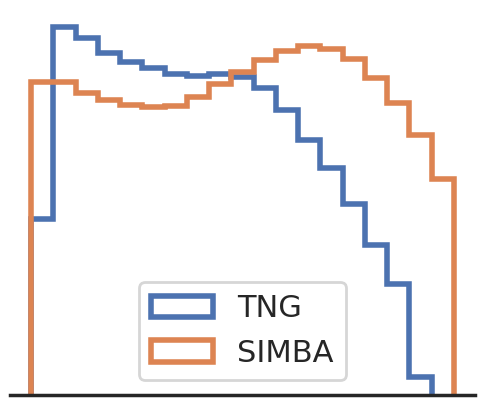

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.hist(maps.ravel(), bins=np.logspace(3, 8, 20), label='TNG', histtype='step', linewidth=4);
ax.hist(Smaps.ravel(), bins=np.logspace(3, 8, 20), label='SIMBA', histtype='step', linewidth=4);
ax.legend()
# plt.xlabel('Temperature')
# plt.ylabel('Count')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
# frame1.axes.yaxis.set_ticklabels([])
# plt.ylim([0, 2e6])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

maps = get_maps(field='HI', data_sim='IllustrisTNG')
Smaps = get_maps(field='HI', data_sim='SIMBA')

maps.min(), Smaps.min(), maps.max(), Smaps.max()

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000


(43.055706, 0.14250141, 20742037000000.0, 8164244000000.0)

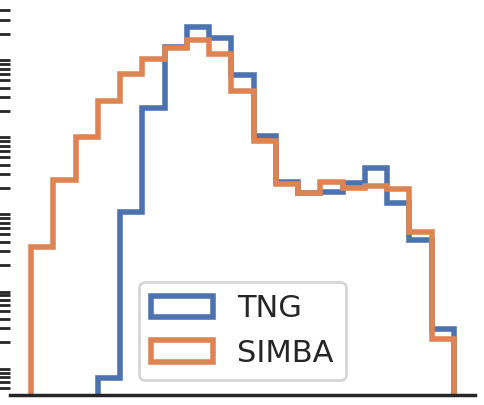

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.hist(maps.ravel(), bins=np.logspace(-1, 13, 20), label='TNG', histtype='step', linewidth=4);
ax.hist(Smaps.ravel(), bins=np.logspace(-1, 13, 20), label='SIMBA', histtype='step', linewidth=4);
ax.legend()
# plt.xlabel('Temperature')
# plt.ylabel('Count')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
# frame1.axes.yaxis.set_ticklabels([])
# plt.ylim([0, 2e6])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

maps = get_maps(field='Mtot', data_sim='IllustrisTNG')
Smaps = get_maps(field='Mtot', data_sim='SIMBA')

maps.min(), Smaps.min(), maps.max(), Smaps.max()

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000


(7132890600.0, 8806955000.0, 1124576300000000.0, 1766318300000000.0)

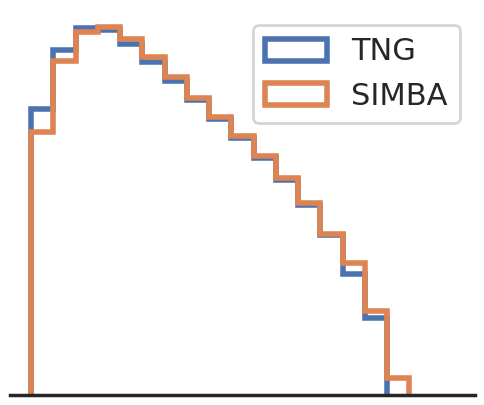

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.hist(maps.ravel(), bins=np.logspace(10, 16, 20), label='TNG', histtype='step', linewidth=4);
ax.hist(Smaps.ravel(), bins=np.logspace(10, 16, 20), label='SIMBA', histtype='step', linewidth=4);
ax.legend()
# plt.xlabel('Temperature')
# plt.ylabel('Count')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
# frame1.axes.yaxis.set_ticklabels([])
# plt.ylim([0, 2e6])

## Print top two trials for all three fields

In [ ]:
print("Mtot")
base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'
field = 'Mtot'
model_sim = 'SIMBA'
study_name = 'wd_dr_hidden_lr_o3'
fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trials = len(study.trials)

losses = np.zeros(trials)
completed_trials = 0
for i,t in enumerate(study.trials):
  losses[i] = t.value
  if t.value is not None:  completed_trials += 1
print('Number of completed trials: %d'%completed_trials)

# Print info of top two trials.
indexes = np.argsort(losses)
for trial_number in indexes[:2]:
  trial = study.trials[trial_number]
  print("\nTrial number:  number {}".format(trial.number))
  print("Loss:          %.5e"%trial.value)
  print("Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("###########################################################################")
print("HI:")
base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'
field = 'HI'
model_sim = 'IllustrisTNG'
study_name = 'wd_dr_hidden_lr_o3'
fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trials = len(study.trials)

losses = np.zeros(trials)
completed_trials = 0
for i,t in enumerate(study.trials):
  losses[i] = t.value
  if t.value is not None:  completed_trials += 1
print('Number of completed trials: %d'%completed_trials)

# Print info of top two trials.
indexes = np.argsort(losses)
for trial_number in indexes[:2]:
  trial = study.trials[trial_number]
  print("\nTrial number:  number {}".format(trial.number))
  print("Loss:          %.5e"%trial.value)
  print("Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("###########################################################################")
print("Temperature:")
base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'
field = 'T'
model_sim = 'IllustrisTNG'
study_name = 'wd_dr_hidden_lr_o3'
fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trials = len(study.trials)

losses = np.zeros(trials)
completed_trials = 0
for i,t in enumerate(study.trials):
  losses[i] = t.value
  if t.value is not None:  completed_trials += 1
print('Number of completed trials: %d'%completed_trials)

# Print info of top two trials.
indexes = np.argsort(losses)
for trial_number in indexes[:2]:
  trial = study.trials[trial_number]
  print("\nTrial number:  number {}".format(trial.number))
  print("Loss:          %.5e"%trial.value)
  print("Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Mtot
Number of completed trials: 51

Trial number:  number 16
Loss:          -1.25476e+01
Params: 
    dr: 0.2932227127901532
    hidden: 8
    lr: 0.0015361051648428922
    wd: 0.07519245458563031

Trial number:  number 43
Loss:          -1.25184e+01
Params: 
    dr: 0.3258598545228232
    hidden: 10
    lr: 0.003566828527316664
    wd: 0.001006546693901829
###########################################################################
HI:
Number of completed trials: 51

Trial number:  number 28
Loss:          -1.32207e+01
Params: 
    dr: 0.12036446689319166
    hidden: 12
    lr: 0.0038589953589558755
    wd: 0.0002513550091681301

Trial number:  number 31
Loss:          -1.32202e+01
Params: 
    dr: 0.07200346341605424
    hidden: 12
    lr: 0.004941944101061687
    wd: 0.0004277330524988745
###########################################################################
Temperature:
Number of completed trials: 52

Trial number:  number 43
Loss:          -1.30537e+01
Params: 
    dr: 0.3987

## Run CKA on the best trial pairs

In [ ]:
base_dir='/content'

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt

--2023-11-25 16:57:15--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_LH_IllustrisTNG.txt’

params_LH_Illustris 100%[===================>]  46.88K  --.-KB/s    in 0.1s    

2023-11-25 16:57:16 (380 KB/s) - ‘params_LH_IllustrisTNG.txt’ saved [48000/48000]



In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_Mtot_all_steps_500_500_o3.db

--2023-11-25 16:57:16--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_Mtot_all_steps_500_500_o3.db
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58368 (57K) [application/octet-stream]
Saving to: ‘IllustrisTNG_o3_Mtot_all_steps_500_500_o3.db’

IllustrisTNG_o3_Mto 100%[===================>]  57.00K  --.-KB/s    in 0.1s    

2023-11-25 16:57:16 (459 KB/s) - ‘IllustrisTNG_o3_Mtot_all_steps_500_500_o3.db’ saved [58368/58368]



In [ ]:
model = model_o3_err_layer_output(5, 0.2, 1, layer_index=10)
model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

models = [model]

total number of parameters in the model = 5881752


In [ ]:
import shutil

field = 'Mtot'
data_sim = 'IllustrisTNG'
model_sim = 'SIMBA'm
study_name = 'wd_dr_hidden_lr_o3'

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else os.path.join(base_dir, f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
  if i%15 in np.arange(splits):
    indexes[count] = i
    count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

batch_size = 50
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,  # IMPORTANT: batch_size=1 gave error.
                                        rot_flip_in_mem=False, verbose=True, shuffle=False)

#########################
trial_1 = 16
# trial_2 = 31
#########################

cka_filename = f'cka_{field}_{model_sim}_{trial_1}_and_{trial_1}_trials_appliedon_{data_sim}_Maps_{batch_size}examples.npy'

print(f'====== Trials {trial_1} and {trial_1} ======')
fweights_1 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
fweights_2 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
fdatabase1 = 'sqlite:////' + f'/content/{model_sim}_o3_{field}_all_steps_500_500_o3.db'
study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
# trial_number_2 = int(fweights_2.split('/')[6].split('_')[3])

models = load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_1, fdatabase2=None)

# Get test results
print('Model 1')
params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)
np.save(cka_filename.replace('cka', 'acc_model_1'), np.vstack([r2, rmse]))
shutil.copy(cka_filename.replace('cka', 'acc_model_1'), os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach/only_single_trial_approach'))
print('Model 2')
params_true2, params_NN, errors_NN = get_test_acc(models[1], test_loader)
assert np.all(params_true == params_true2)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)
np.save(cka_filename.replace('cka', 'acc_model_2'), np.vstack([r2, rmse]))
shutil.copy(cka_filename.replace('cka', 'acc_model_2'), os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach/only_single_trial_approach'))
print("====================")

# print("=====")
# print(params_true)
# print(params_NN)
# print("=====")

# Calculate CKA
data_batch = []
for i, (x, y) in enumerate(test_loader):
  if i == 0:
    data_batch.append(x)
    break
  # if i == 0:
  #   break
x = torch.vstack(data_batch)
print(x.shape)
with torch.no_grad():
  _, intermediate_outputs_A = models[0](x)
  _, intermediate_outputs_B = models[1](x)
  # sim = compare_activations(models[0], models[1], x)
  # test_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)
  sim = get_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)

# Save CKA
np.save(cka_filename, sim)
# shutil.copy(cka_filename, os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach/only_single_trial_approach'))
# shutil.copy(cka_filename.replace('cka', 'acc_model_1'), base_dir+'for_final_paper/')
# shutil.copy(cka_filename.replace('cka', 'acc_model_2'), base_dir+'for_final_paper/')

content
torch.Size([50, 1, 256, 256])


ValueError: ignored

In [ ]:
yy = models[0](x)
yy.shape

torch.Size([50, 80, 32, 32])

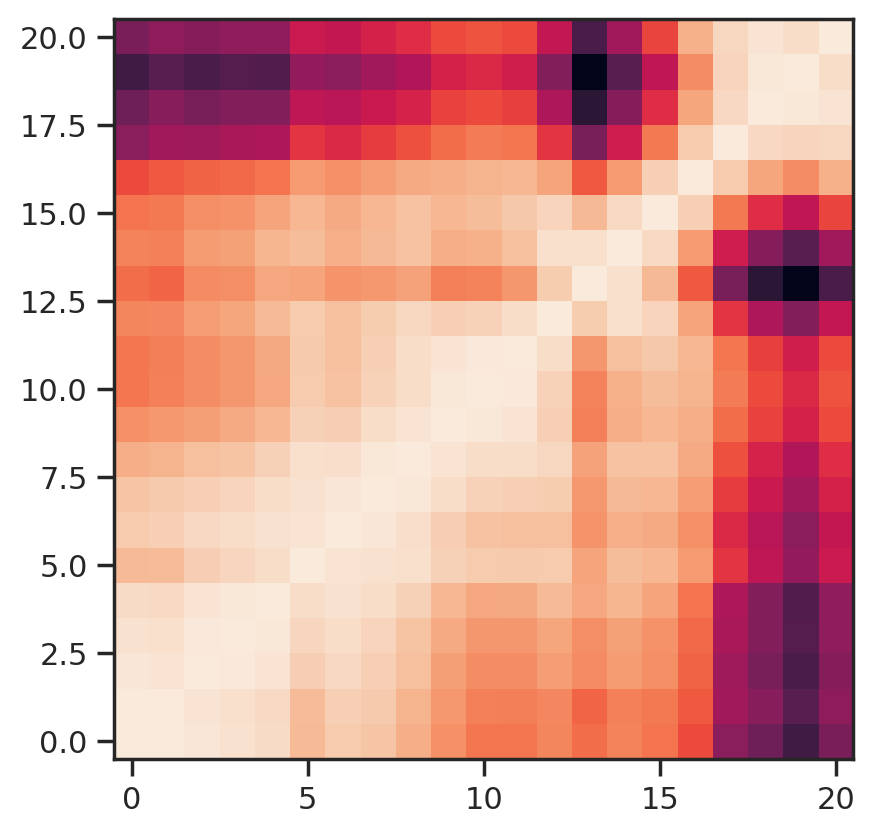

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(np.load('/content/cka_T_IllustrisTNG_37_and_37_trials_appliedon_SIMBA_Maps_32examples.npy'))
ax.axes.invert_yaxis()

## Temporary: power spectrum, histogram

In [ ]:
!pip install Pylians

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached hdf5plugin-4.1.3-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 417, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.p

In [ ]:
import Pk_library.Pk_library as PKL

def ps_2d(arr, BoxSize=21, vel_field=False):
    arr = arr.astype(np.float32)
    # if not vel_field:
    #   # Calculate density contrast.
    #   arr /= np.mean(arr, dtype=np.float64); arr -= 1.0

    MAS = 'None'
    threads = 2
    Pk2D2 = PKL.Pk_plane(arr, BoxSize, MAS, threads)
    # get the attributes of the routine
    k2      = Pk2D2.k      #k in h/Mpc
    Pk2     = Pk2D2.Pk     #Pk in (Mpc/h)^2
#     Nmodes = Pk2D2.Nmodes #Number of modes in the different k bins
    return k2, Pk2

def spectra(arr):
  eigenvalues_ss, _ = np.linalg.eig(arr)
  return np.real(eigenvalues_ss)

ModuleNotFoundError: ignored

In [ ]:
import shutil

trials_1 = np.load(os.path.join(base_dir, 'trials_1.npy'))
trials_2 = np.load(os.path.join(base_dir, 'trials_2.npy'))

In [ ]:
from  sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def get_pca_components(arr):
  scaler = StandardScaler()
  scaled_arr = scaler.fit_transform(arr)
  pca = PCA(n_components=21)
  pca.fit(scaled_arr)
  return pca.singular_values_, pca


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.02 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


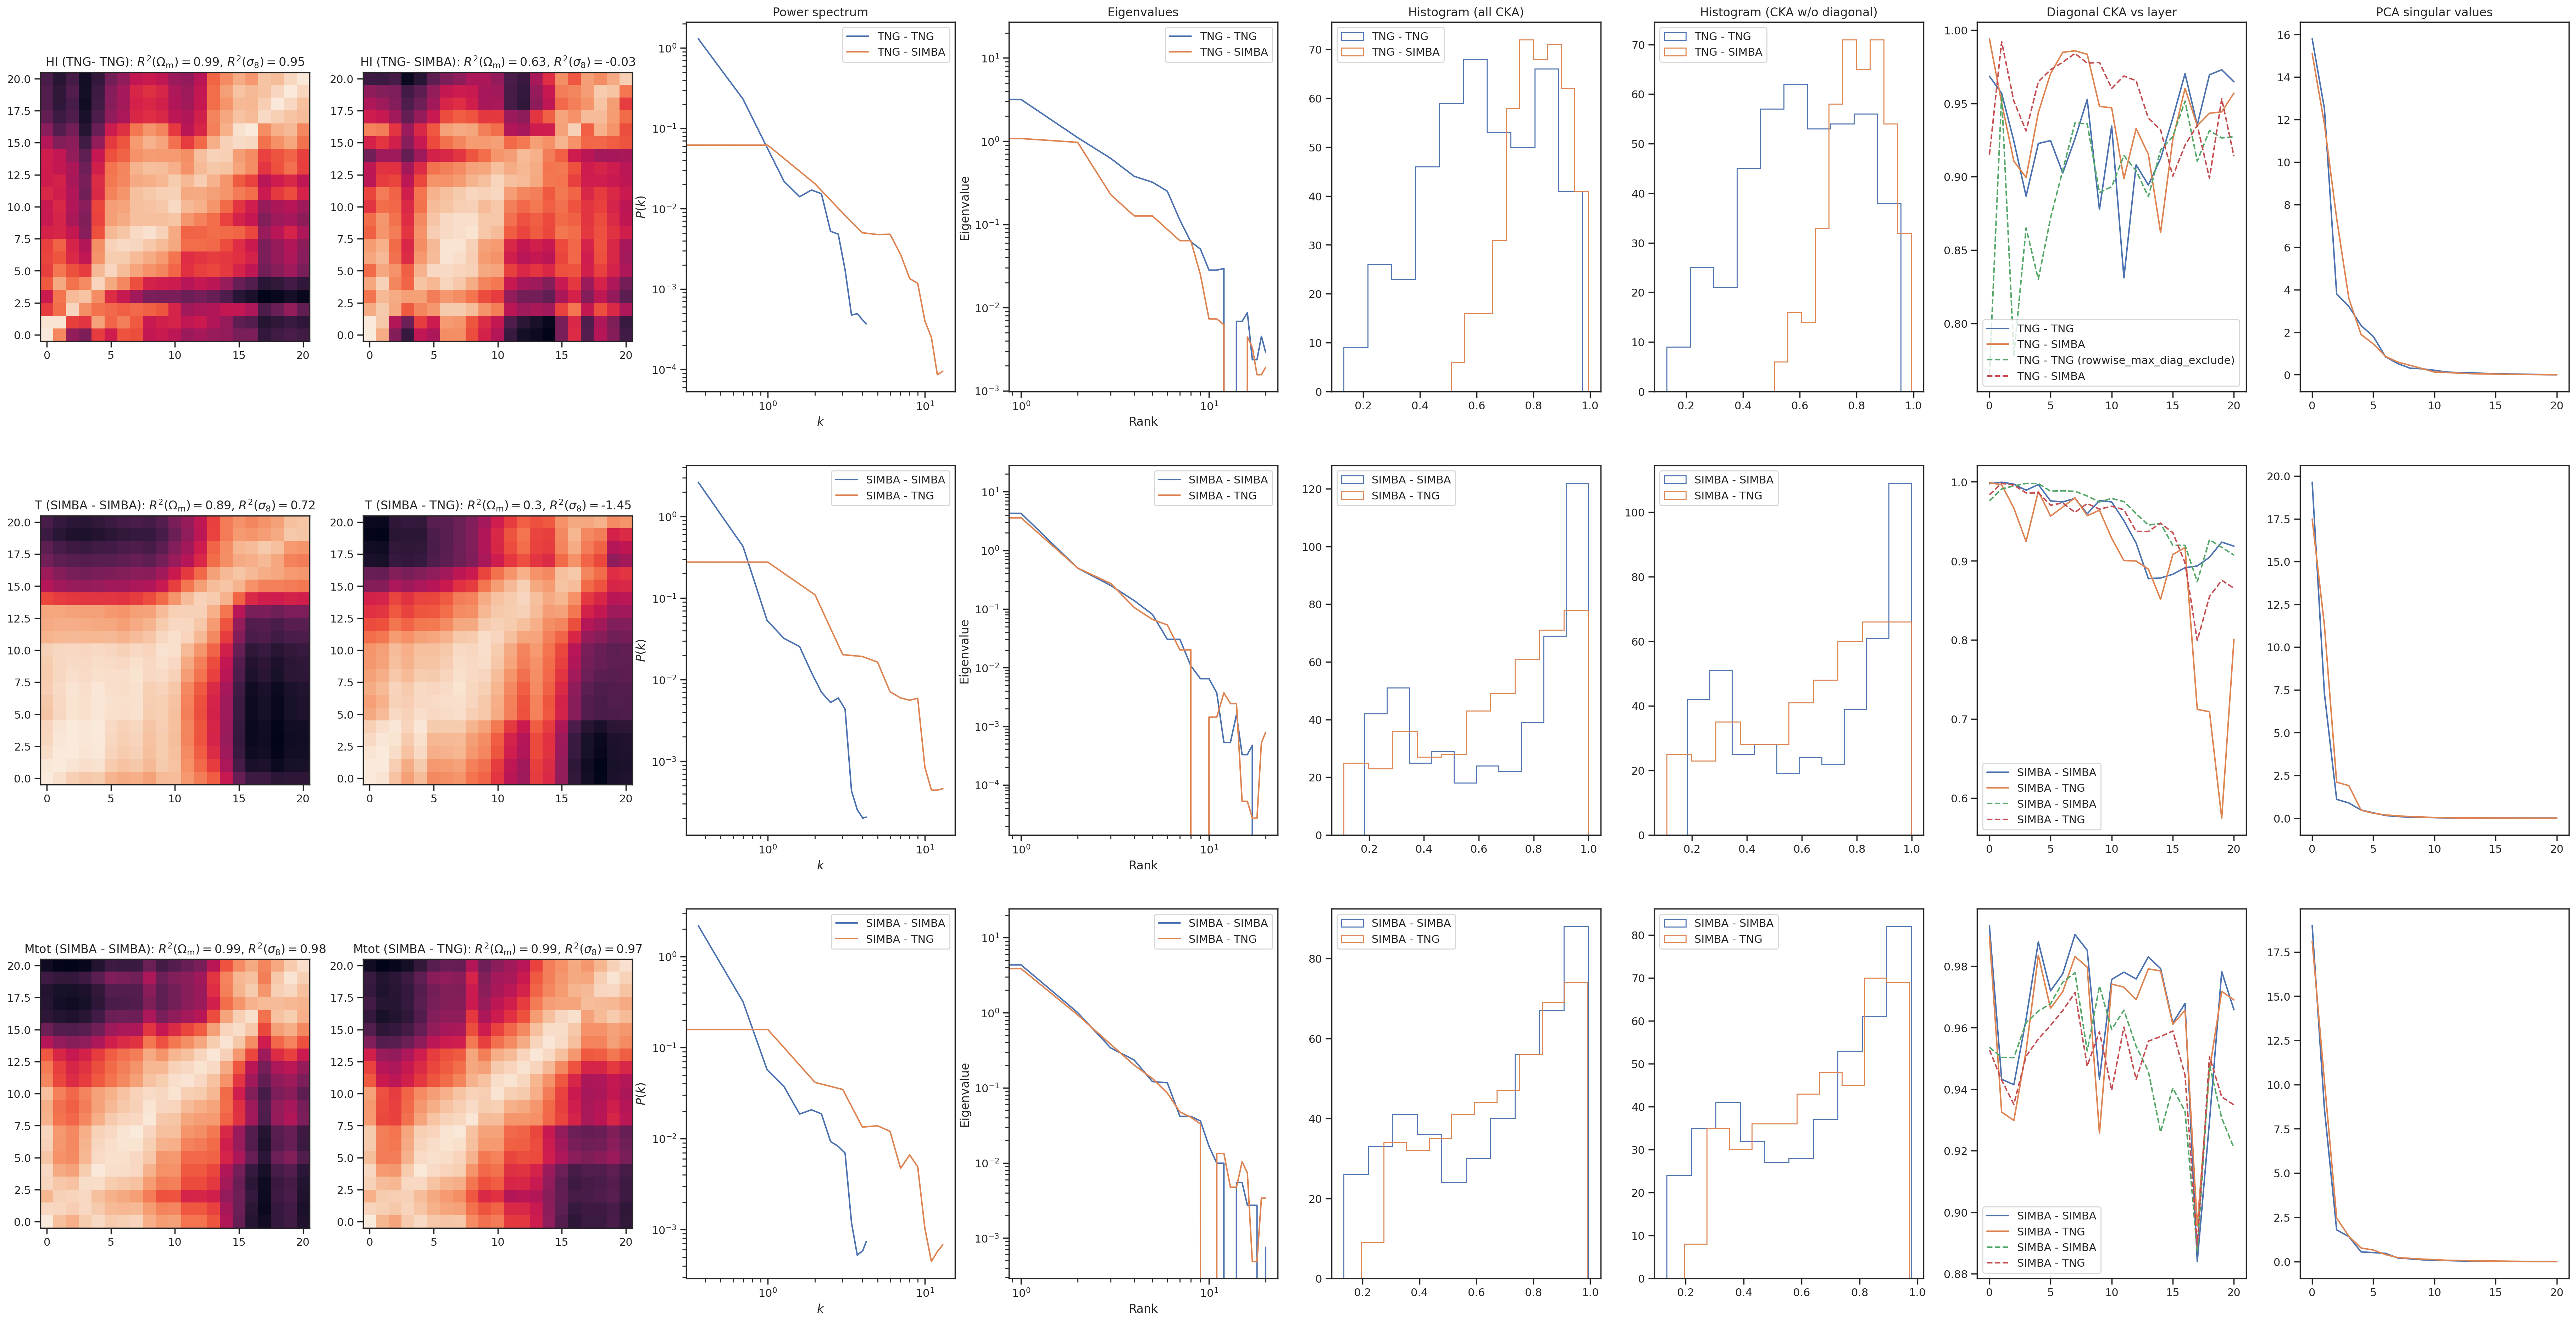

In [ ]:
trial_1_Mtot = 16
trial_2_Mtot = 43
trial_1_HI = 28
trial_2_HI = 31
trial_1_T = 37
trial_2_T = 48

HI_TT_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
HI_TT_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
HI_TT_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

HI_TT_pca = get_pca_components(HI_TT_cka)

# R2 scores
HI_TT_acc_omegam = np.round((HI_TT_acc1[0][0] + HI_TT_acc2[0][0]) / 2, 2)
HI_TT_acc_sigma8 = np.round((HI_TT_acc1[0][1] + HI_TT_acc2[0][1]) / 2, 2)

HI_TS_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')
HI_TS_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')
HI_TS_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')

HI_TS_pca = get_pca_components(HI_TS_cka)

HI_TS_acc_omegam = np.round((HI_TS_acc1[0][0] + HI_TS_acc2[0][0]) / 2, 2)
HI_TS_acc_sigma8 = np.round((HI_TS_acc1[0][1] + HI_TS_acc2[0][1]) / 2, 2)

T_SS_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')
T_SS_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')
T_SS_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')

T_SS_pca = get_pca_components(T_SS_cka)

T_SS_acc_omegam = np.round((T_SS_acc1[0][0] + T_SS_acc2[0][0]) / 2, 2)
T_SS_acc_sigma8 = np.round((T_SS_acc1[0][1] + T_SS_acc2[0][1]) / 2, 2)

T_ST_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
T_ST_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
T_ST_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_T_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

T_ST_pca = get_pca_components(T_ST_cka)

T_ST_acc_omegam = np.round((T_ST_acc1[0][0] + T_ST_acc2[0][0]) / 2, 2)
T_ST_acc_sigma8 = np.round((T_ST_acc1[0][1] + T_ST_acc2[0][1]) / 2, 2)

Mtot_SS_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')
Mtot_SS_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')
Mtot_SS_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')

Mtot_SS_pca = get_pca_components(Mtot_SS_cka)

Mtot_SS_acc_omegam = np.round((Mtot_SS_acc1[0][0] + Mtot_SS_acc2[0][0]) / 2, 2)
Mtot_SS_acc_sigma8 = np.round((Mtot_SS_acc1[0][1] + Mtot_SS_acc2[0][1]) / 2, 2)

Mtot_ST_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
Mtot_ST_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
Mtot_ST_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

Mtot_ST_pca = get_pca_components(Mtot_ST_cka)

Mtot_ST_acc_omegam = np.round((Mtot_ST_acc1[0][0] + Mtot_ST_acc2[0][0]) / 2, 2)
Mtot_ST_acc_sigma8 = np.round((Mtot_ST_acc1[0][1] + Mtot_ST_acc2[0][1]) / 2, 2)

HI_TT_pspec = ps_2d(HI_TT_cka)
HI_TS_pspec = ps_2d(HI_TS_cka)
T_SS_pspec = ps_2d(T_SS_cka)
T_ST_pspec = ps_2d(T_ST_cka)
Mtot_SS_pspec = ps_2d(Mtot_SS_cka)
Mtot_ST_pspec = ps_2d(Mtot_ST_cka)

HI_TT_spec = spectra(HI_TT_cka)
HI_TS_spec = spectra(HI_TS_cka)
T_SS_spec = spectra(T_SS_cka)
T_ST_spec = spectra(T_ST_cka)
Mtot_SS_spec = spectra(Mtot_SS_cka)
Mtot_ST_spec = spectra(Mtot_ST_cka)

def row_wise_max_exclude_diagonal(A):
  B = np.copy(A)   # copy A
  B[np.diag_indices_from(B)] = -np.inf  # fill up diagonals with - infty
  return np.max(B,axis = 1) # compute maximum

titles = ['HI (TNG- TNG)', 'HI (TNG- SIMBA)', 'T (SIMBA - SIMBA)', 'T (SIMBA - TNG)', 'Mtot (SIMBA - SIMBA)', 'Mtot (SIMBA - TNG)']

def get_non_diagonal(arr):
  return arr[~np.eye(arr.shape[0],dtype=bool)]

def get_result_string(acc_omegam, acc_sigma8):
  return r'$R^{2}(\Omega_{\rm m})=$' + f'{acc_omegam}, ' + r'$R^{2}(\sigma_8)=$' + f'{acc_sigma8}'

fig, ax = plt.subplots(3, 8, figsize=(46, 23))
ax[0, 0].imshow(HI_TT_cka); ax[0, 1].imshow(HI_TS_cka);
ax[0, 0].set_title(f'{titles[0]}: {get_result_string(HI_TT_acc_omegam, HI_TT_acc_sigma8)}'); ax[0, 1].set_title(f'{titles[1]}: {get_result_string(HI_TS_acc_omegam, HI_TS_acc_sigma8)}')
ax[0, 2].plot(HI_TT_pspec[0], HI_TT_pspec[1], label=f'TNG - TNG'); ax[0, 2].plot(HI_TS_pspec[1], label='TNG - SIMBA');
ax[0, 3].plot(HI_TT_spec, label='TNG - TNG'); ax[0, 3].plot(HI_TS_spec, label='TNG - SIMBA');
ax[0, 4].hist(HI_TT_cka.flatten(), histtype='step', label='TNG - TNG'); ax[0, 4].hist(HI_TS_cka.flatten(), histtype='step', label='TNG - SIMBA')
ax[0, 5].hist(get_non_diagonal(HI_TT_cka).flatten(), histtype='step', label='TNG - TNG'); ax[0, 5].hist(get_non_diagonal(HI_TS_cka).flatten(), histtype='step', label='TNG - SIMBA')
ax[0, 6].plot(np.diag(HI_TT_cka), label='TNG - TNG'); ax[0, 6].plot(np.diag(HI_TS_cka), label='TNG - SIMBA')
ax[0, 6].plot(row_wise_max_exclude_diagonal(HI_TT_cka), label='TNG - TNG (rowwise_max_diag_exclude)', linestyle='dashed'); ax[0, 6].plot(row_wise_max_exclude_diagonal(HI_TS_cka), label='TNG - SIMBA', linestyle='dashed')
ax[0, 7].plot(HI_TT_pca[0], label='TNG - TNG'); ax[0, 7].plot(HI_TS_pca[0], label='TNG - SIMBA')

ax[1, 0].imshow(T_SS_cka); ax[1, 1].imshow(T_ST_cka);
ax[1, 0].set_title(f'{titles[2]}: {get_result_string(T_SS_acc_omegam, T_SS_acc_sigma8)}'); ax[1, 1].set_title(f'{titles[3]}: {get_result_string(T_ST_acc_omegam, T_ST_acc_sigma8)}')
ax[1, 2].plot(T_SS_pspec[0], T_SS_pspec[1], label='SIMBA - SIMBA'); ax[1, 2].plot(T_ST_pspec[1], label='SIMBA - TNG');
ax[1, 3].plot(T_SS_spec, label='SIMBA - SIMBA'); ax[1, 3].plot(T_ST_spec, label='SIMBA - TNG');
ax[1, 4].hist(T_SS_cka.flatten(), histtype='step', label='SIMBA - SIMBA'); ax[1, 4].hist(T_ST_cka.flatten(), histtype='step', label='SIMBA - TNG')
ax[1, 5].hist(get_non_diagonal(T_SS_cka).flatten(), histtype='step', label='SIMBA - SIMBA'); ax[1, 5].hist(get_non_diagonal(T_ST_cka).flatten(), histtype='step', label='SIMBA - TNG')
ax[1, 6].plot(np.diag(T_SS_cka), label='SIMBA - SIMBA'); ax[1, 6].plot(np.diag(T_ST_cka), label='SIMBA - TNG')
ax[1, 6].plot(row_wise_max_exclude_diagonal(T_SS_cka), label='SIMBA - SIMBA', linestyle='dashed'); ax[1, 6].plot(row_wise_max_exclude_diagonal(T_ST_cka), label='SIMBA - TNG', linestyle='dashed')
ax[1, 7].plot(T_SS_pca[0], label='SIMBA - SIMBA'); ax[1, 7].plot(T_ST_pca[0], label='SIMBA - TNG')

ax[2, 0].imshow(Mtot_SS_cka); ax[2, 1].imshow(Mtot_ST_cka);
ax[2, 0].set_title(f'{titles[4]}: {get_result_string(Mtot_SS_acc_omegam, Mtot_SS_acc_sigma8)}'); ax[2, 1].set_title(f'{titles[5]}: {get_result_string(Mtot_ST_acc_omegam, Mtot_ST_acc_sigma8)}')
ax[2, 2].plot(Mtot_SS_pspec[0], Mtot_SS_pspec[1], label='SIMBA - SIMBA'); ax[2, 2].plot(Mtot_ST_pspec[1], label='SIMBA - TNG');
ax[2, 3].plot(Mtot_SS_spec, label='SIMBA - SIMBA'); ax[2, 3].plot(Mtot_ST_spec, label='SIMBA - TNG');
ax[2, 4].hist(Mtot_SS_cka.flatten(), histtype='step', label='SIMBA - SIMBA'); ax[2, 4].hist(Mtot_ST_cka.flatten(), histtype='step', label='SIMBA - TNG')
ax[2, 5].hist(get_non_diagonal(Mtot_SS_cka).flatten(), histtype='step', label='SIMBA - SIMBA'); ax[2, 5].hist(get_non_diagonal(Mtot_ST_cka).flatten(), histtype='step', label='SIMBA - TNG')
ax[2, 6].plot(np.diag(Mtot_SS_cka), label='SIMBA - SIMBA'); ax[2, 6].plot(np.diag(Mtot_ST_cka), label='SIMBA - TNG')
ax[2, 6].plot(row_wise_max_exclude_diagonal(Mtot_SS_cka), label='SIMBA - SIMBA', linestyle='dashed'); ax[2, 6].plot(row_wise_max_exclude_diagonal(Mtot_ST_cka), label='SIMBA - TNG', linestyle='dashed')
ax[2, 7].plot(Mtot_SS_pca[0], label='SIMBA - SIMBA'); ax[2, 7].plot(Mtot_ST_pca[0], label='SIMBA - TNG')

ax[0, 2].legend(); ax[0, 3].legend(); ax[0, 4].legend(), ax[0, 5].legend(); ax[0, 6].legend()
ax[1, 2].legend(); ax[1, 3].legend(); ax[1, 4].legend(), ax[1, 5].legend(); ax[1, 6].legend()
ax[2, 2].legend(); ax[2, 3].legend(); ax[2, 4].legend(), ax[2, 5].legend(); ax[2, 6].legend()

ax[0, 2].set_title('Power spectrum')
ax[0, 3].set_title('Eigenvalues')
ax[0, 4].set_title('Histogram (all CKA)')
ax[0, 5].set_title('Histogram (CKA w/o diagonal)')
ax[0, 6].set_title('Diagonal CKA vs layer')
ax[0, 7].set_title('PCA singular values')

for i in range(3):
  for j in range(2):
    ax[i, j].axes.invert_yaxis()

for i in range(3):
  for j in [2, 3]:
    ax[i, j].set_xscale('log'); ax[i, j].set_yscale('log')

for i in range(3):
  ax[i, 2].set_ylabel(r'$P(k)$'); ax[i, 2].set_xlabel(r'$k$')
  ax[i, 3].set_ylabel('Eigenvalue'); ax[i, 3].set_xlabel('Rank')

# jj = 0
# for i in range(3):
#   for j in range(2):
#     ax[i, j].set_title(titles[jj])
#     jj += 1

# plt.tight_layout()

In [ ]:
def diagonalness_measure(cka):
  assert cka.shape[0] == cka.shape[1]
  d = cka.shape[0]
  j = np.ones(cka.shape[0])
  r = np.arange(1, d+1, 1)
  r2 = r**2
  n = np.sum(j.dot(cka).dot(j.T))
  sum_x = np.sum(r.dot(cka).dot(j.T))
  sum_y = np.sum(j.dot(cka).dot(r.T))
  sum_x2 = np.sum(r2.dot(cka).dot(j.T))
  sum_y2 = np.sum(j.dot(cka).dot(r2.T))
  sum_xy = np.sum(r.dot(cka).dot(r.T))

  corr = (n * sum_xy - sum_x * sum_y) / (np.sqrt(n * sum_x2 - sum_x**2) * np.sqrt(n * sum_y2 - sum_y**2))
  return corr

In [ ]:
print(
    diagonalness_measure(HI_TT_cka),
    diagonalness_measure(HI_TS_cka),
    diagonalness_measure(T_SS_cka),
    diagonalness_measure(T_ST_cka),
    diagonalness_measure(Mtot_SS_cka),
    diagonalness_measure(Mtot_ST_cka)
)

0.25199992735771953 0.06944338463392917 0.2872185175829606 0.2985999232794915 0.32079918199333446 0.2753940093974148


## 2. Accuracy of internal layers

### 2.1 Our approach

This also stores the accuracy of the entire network (which can be printed on the titles of CKA matrices).

By "accuracy" we mean the $R^2$ score.

This is the list. Set `layers_to_zero_out_weights_indices` same as the index of layers in the below list which you want to zero out the weights.

So to zero out C01, C02, and C03, `layers_to_zero_out_weights_indices = [0,1,2,3,4,5]`. The model definition internally also zeroes out the corresponding batch norm layers, but the ReLU still persists since it is not learned.
```
'module.C01.weight',
'module.C01.bias',
'module.C02.weight',
'module.C02.bias',
'module.C03.weight',
'module.C03.bias',
'module.C11.weight',
'module.C11.bias',
'module.C12.weight',
'module.C12.bias',
'module.C13.weight',
'module.C13.bias',
'module.C21.weight',
'module.C21.bias',
'module.C22.weight',
'module.C22.bias',
'module.C23.weight',
'module.C23.bias',
'module.C31.weight',
'module.C31.bias',
'module.C32.weight',
'module.C32.bias',
'module.C33.weight',
'module.C33.bias',
'module.C41.weight',
'module.C41.bias',
'module.C42.weight',
'module.C42.bias',
'module.C43.weight',
'module.C43.bias',
'module.C51.weight',
'module.C51.bias',
'module.C52.weight',
'module.C52.bias',
'module.C53.weight',
'module.C53.bias',
'module.C61.weight',
'module.C61.bias',
 ```

 For FC, pass indices from this list in the `f_indices` argument:
 ```
 'module.FC1.weight',
'module.FC1.bias',
'module.FC2.weight',
'module.FC2.bias'
```

**IMPORTANT** TODO: When doing these experiments, params have the same value for all maps, which was confusing. Indeed when no weights are turned off, all params are diff as expected. So there is smth happening that's why we get a flat curve.

We don't really need to train classifier after representation and if we fix this and get expected, then we done.

Also, why are parameters for all maps in test set the same? Was this expected?


**LATEST**: What if we don't set their weights to zero but make them identity layer? Because I think zeroing out weights gives that degeneracy in the output regardless of which layer in the middel has its weights zeroed out. Note Identity and setting all weights to one and bias to zero are not the same.

In [ ]:
import glob
import os
import numpy as np

base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'

name_list = [
  'module.C01.weight',
  'module.C01.bias',
  'module.C02.weight',
  'module.C02.bias',
  'module.C03.weight',
  'module.C03.bias',
  'module.C11.weight',
  'module.C11.bias',
  'module.C12.weight',
  'module.C12.bias',
  'module.C13.weight',
  'module.C13.bias',
  'module.C21.weight',
  'module.C21.bias',
  'module.C22.weight',
  'module.C22.bias',
  'module.C23.weight',
  'module.C23.bias',
  'module.C31.weight',
  'module.C31.bias',
  'module.C32.weight',
  'module.C32.bias',
  'module.C33.weight',
  'module.C33.bias',
  'module.C41.weight',
  'module.C41.bias',
  'module.C42.weight',
  'module.C42.bias',
  'module.C43.weight',
  'module.C43.bias',
  'module.C51.weight',
  'module.C51.bias',
  'module.C52.weight',
  'module.C52.bias',
  'module.C53.weight',
  'module.C53.bias',
  'module.C61.weight',
  'module.C61.bias',
]
f_name_list = [
  'module.FC1.weight',
  'module.FC1.bias',
  'module.FC2.weight',
  'module.FC2.bias'
]

In [ ]:
l = nn.Linear(3,3)
l.weight.data.copy_(torch.zeros(3,3))
l.bias.data.fill_(0)
xx=torch.randn((3,3))
l(xx), xx

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]], grad_fn=<AddmmBackward0>),
 tensor([[-1.2858e+00, -1.5311e+00,  1.2148e+00],
         [-9.8377e-01,  6.4618e-01,  4.6987e-01],
         [ 8.3767e-01, -1.6414e+00,  5.8671e-04]]))

In [ ]:
trials_1 = np.load(os.path.join(base_dir, 'trials_1.npy'))
trials_2 = np.load(os.path.join(base_dir, 'trials_2.npy'))

assert len(np.intersect1d(trials_1, trials_2)) == 0
field = 'T'
data_sim = 'SIMBA'
model_sim = 'SIMBA'
study_name = 'wd_dr_hidden_lr_o3'

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')  # Note: f'params_LH_Nbody_{data_sim}.txt' ONLY for Nbody, else f'params_LH_{data_sim}.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                        rot_flip_in_mem=False, verbose=True, shuffle=False)

##################################################################
layers_to_zero_out_weights_indices_list = []
for i in np.arange(2, 40, 2):
  layers_to_zero_out_weights_indices_list.append(np.arange(i, 40))
  # layers_to_zero_out_weights_indices_list.append([i])

# At None at the last to NOT zero out weights of any layer.
layers_to_zero_out_weights_indices_list.append(None)
##################################################################

def set_weights_zero_layers(model, layers_to_zero_out_weights_indices=None, f_indices=None):
  """layers_to_zero_out_weights_indices specifies indices only for conv and bn layers. Use `f_indices` for linear layers."""
  params = list(model.named_parameters())
  cp = [p for p in params if p[0].startswith('module.C')]  # Convolutional layer params
  bp = [p for p in params if p[0].startswith('module.B')]  # Batch Norm layer params
  fp = [p for p in params if p[0].startswith('module.FC')]  # Linear layer params
  cp_indices = [params.index(b) for b in cp]  # Indices of conv layers in named_parameters.
  bp_indices = [params.index(b) for b in bp]  # Indices of batch norm layers in named_parameters.
  fp_indices = [params.index(b) for b in fp]  # Indices of linear layers in named_parameters.

  if layers_to_zero_out_weights_indices is not None:
    for i, m in enumerate(model.named_parameters()):
      if i in cp_indices:  # Is the current layer is a convolutional layer.
        if cp_indices.index(i) in layers_to_zero_out_weights_indices:  # If the current convolutional layer needs to have its weight and bias to set to zero as specified by the user.
          #if '.bias' not in m[0]:
          print(f'Conv: {m[0]}')
          m[1].data.fill_(0)  # Fill convolutional layer weights to zero.
      elif i in bp_indices:  # Is the current layer is a batch norm layer.
        if bp_indices.index(i) in layers_to_zero_out_weights_indices:  # If the current batch norm layer needs to have its weight and bias to set to zero as specified by the user.
          # The user only specifies the indexes in the cp_indices, but the corresponding batch norm layers also have the same indices in bp_indices, hence we can use it as it is.
          #if '.bias' not in m[0]:
          print(f'BN: {m[0]}')
          m[1].data.fill_(0)  # Fill batch norm layer weights to zero.
      elif i in fp_indices:
        if f_indices is not None:
          if fp_indices.index(i) in f_indices:
            #if '.bias' not in m[0]:
            print(f'Linear: {m[0]}')
            m[1].data.fill_(0)  # Fill linear layer weights to zero.
  print("=================")

for trial_1, trial_2 in zip(trials_1, trials_2):
  print(f'====== Trials {trial_1} and {trial_2} ======')

  fweights_1 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
  fweights_2 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_2}_all_steps_500_500_o3.pt')
  fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

  study = optuna.load_study(study_name=study_name, storage=fdatabase1)

  trial_number_1 = int(fweights_1.split('/')[6].split('_')[3])
  trial_number_2 = int(fweights_2.split('/')[6].split('_')[3])

  # Zero out weights of layers progressively.
  for jj, layers_to_zero_out_weights_indices in enumerate(layers_to_zero_out_weights_indices_list):
    models = load_two_models_for_similarity_measure(
        fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None, acc_internal_layer=True
    )

    print(f'Zeroing out weights of layers with these indices: {layers_to_zero_out_weights_indices}')
    set_weights_zero_layers(models[0], layers_to_zero_out_weights_indices=layers_to_zero_out_weights_indices, f_indices=None)
    set_weights_zero_layers(models[1], layers_to_zero_out_weights_indices=layers_to_zero_out_weights_indices, f_indices=None)

    f = open(f'{trial_1}_{trial_2}_{jj}.txt', 'w' )
    f.write( 'dict = ' + repr(list(models[0].named_parameters())) + '\n' )
    f.close()

    # Get test results
    print('Model 1')
    params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
    print(params_true)
    print(params_NN)
    r2 = get_r2_score(params_true, params_NN)
    rmse = get_rmse(params_true, params_NN)
    print(r2)
    print(rmse)
    np.save(f'internal_acc_{field}_{data_sim}_{model_sim}_{jj}_TRIALS_{trial_number_1}_{trial_number_2}_model1.npy', [r2, rmse])
    print('Model 2')
    params_true, params_NN, errors_NN = get_test_acc(models[1], test_loader)
    r2 = get_r2_score(params_true, params_NN)
    rmse = get_rmse(params_true, params_NN)
    print(r2)
    print(rmse)
    np.save(f'internal_acc_{field}_{data_sim}_{model_sim}_{jj}_TRIALS_{trial_number_1}_{trial_number_2}_model2.npy', [r2, rmse])
    print("====================")

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
Found 1 channels
Reading data...
(5000, 256, 256) 5000
2.215e+02 < F(all|orig) < 2.636e+11
2.345 < F(all|resc)  < 11.421
-2.706 < F(all|norm) < 4.795
====== Trials 4 and 48 ======
Assuming same database for the two models...
GPUs not available

Trial number: 4
Trial number:  number 4
Loss:          -8.19581e+00
Params: 
    dr: 0.22945872856588215
    hidden: 7
    lr: 2.5265205743946002e-05
    wd: 9.363316442951345e-07
total number of parameters in the model = 11521592
Weights loaded

Trial number: 48
Trial number:  number 48
Loss:          -1.10128e+01
Params: 
    dr: 0.8802252508487907
    hidden: 11
    lr: 0.0008847744908348276
    wd: 9.847549990709975e-06
total number of parameters in the model = 28436376
Weights loaded
Zeroing out weights of layers with these indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Conv: module.C02.weight
C

KeyboardInterrupt: ignored

In [ ]:
e=np.load('internal_acc_T_SIMBA_SIMBA_11_TRIALS_4_48_model1.npy')
t=np.load('internal_acc_T_SIMBA_SIMBA_12_TRIALS_4_48_model1.npy')
e, t

(array([[-2.11350254, -1.46272202, -0.71576938, -0.32908483, -0.98654031,
         -1.09545634],
        [ 0.23552862,  0.21388696,  0.17451261,  0.09983335,  0.19903378,
          0.15909795]]),
 array([[-2.11350254, -1.46272202, -0.71576938, -0.32908483, -0.98654031,
         -1.09545634],
        [ 0.23552862,  0.21388696,  0.17451261,  0.09983335,  0.19903378,
          0.15909795]]))

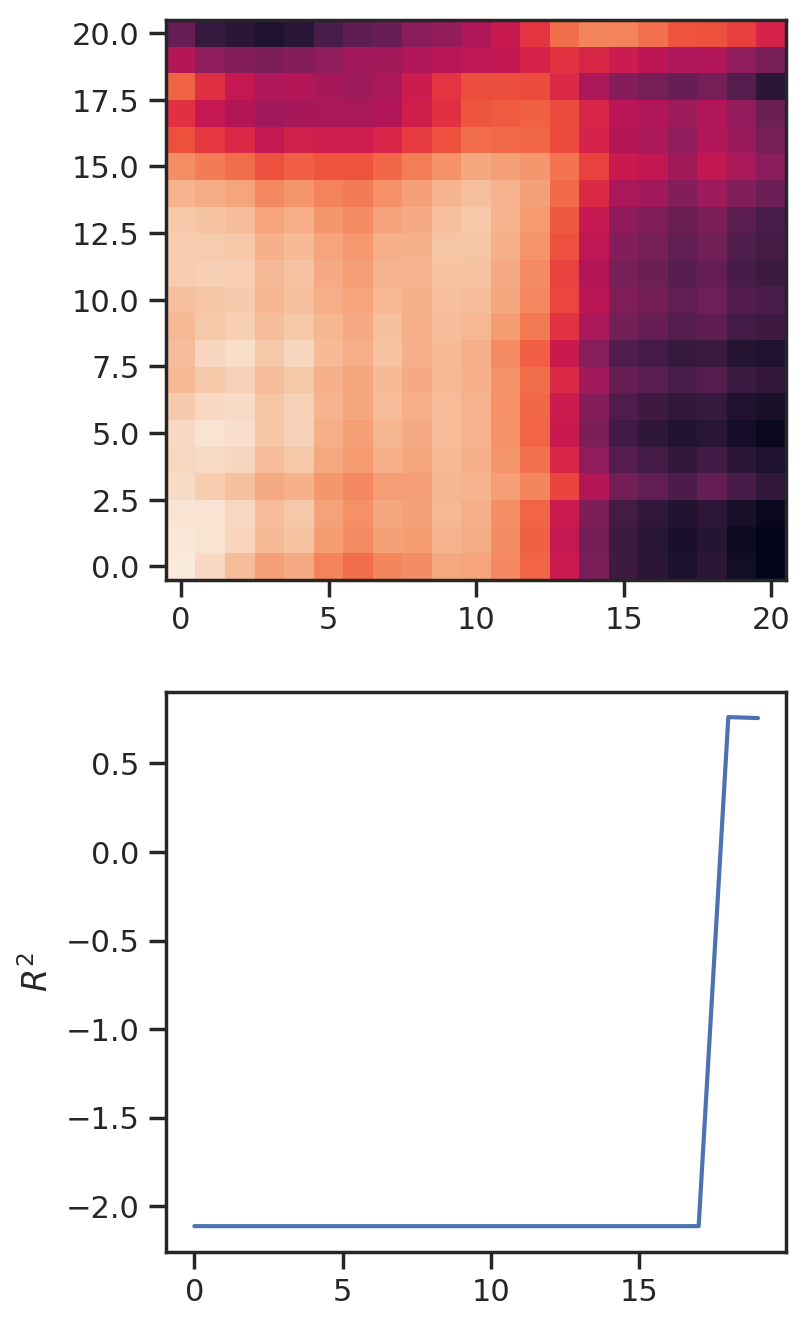

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
x = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/results_latest/cka_T_SIMBA_4_and_48_trials_appliedon_SIMBA_Maps_16examples.npy')
ax[0].imshow(x, origin='lower', aspect='auto')

import glob
l = sorted(glob.glob('internal*_T_SIMBA_SIMBA_*TRIALS_4_48*model1.npy'), key=lambda x: int(x.split('_')[5]))

my_list = []

for f in l:
  r2_rmse = np.load(f)
  r2_omega = r2_rmse[0][0]
  my_list.append(r2_omega)

ax[1].set_ylabel('$R^2$')
ax[1].plot(my_list);

## 2.2 Change layer to identity function gradually.

In [ ]:
import glob
import os
import numpy as np

base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'

**IMPORTANT TODO: We should gradually set layers to identity startingt from the end and not from the start...by doing from start as we do  now, it doesn't make sense since we want to check how R2 changes as depth changes.**

In [ ]:
# module_indices_list = [
#     [None],
#     [0,3,41],
#     [0,3,41,1,4,42],
#     [0,3,41,1,4,42,2,5,43],
#     [0,3,41,1,4,42,2,5,43,6,9,44],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55,30,33,56],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55,30,33,56,31,34,57],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55,30,33,56,31,34,57,32,35,58],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55,30,33,56,31,34,57,32,35,58,36,37,59],
#     [0,3,41,1,4,42,2,5,43,6,9,44,7,10,45,8,11,46,12,15,47,13,16,48,14,17,49,18,21,50,19,22,51,20,23,52,24,27,53,25,28,54,26,29,55,30,33,56,31,34,57,32,35,58,36,37,59,38,60]
# ]

module_indices_list = [
    None,
    [38,60],
    [38,60,36,37,59],
    [38,60,36,37,59,32,35,58],
    [38,60,36,37,59,32,35,58,31,34,57],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46,7,10,45],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46,7,10,45,6,9,44],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46,7,10,45,6,9,44,2,5,43],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46,7,10,45,6,9,44,2,5,43,1,4,42],
    [38,60,36,37,59,32,35,58,31,34,57,30,33,56,26,29,55,25,28,54,24,27,53,20,23,52,19,22,51,18,21,50,14,17,49,13,16,48,12,15,47,8,11,46,7,10,45,6,9,44,2,5,43,1,4,42,0,3,41]
]

def set_layers_to_identity(model, module_indices=None):
  if module_indices is None:
    return

  _mnames = []
  for module_name, module in model.named_modules():
    _mnames.append(module_name)

  candidate_names = []

  for i, module_name in enumerate(_mnames):
    if i-2 in module_indices:
      candidate_names.append(_mnames[i])
      setattr(model, _mnames[i], nn.Identity())  # i-2 instead of i

  print(candidate_names)

In [ ]:
trials_1 = np.load(os.path.join(base_dir, 'trials_1.npy'))
trials_2 = np.load(os.path.join(base_dir, 'trials_2.npy'))

assert len(np.intersect1d(trials_1, trials_2)) == 0
field = 'T'
data_sim = 'IllustrisTNG'
model_sim = 'IllustrisTNG'
study_name = 'wd_dr_hidden_lr_o3'

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 16  # for training logistic regression classifier
lr         = 1e-3
wd         = 0.0005  #value of weight decay
dr         = 0.2    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1
epochs     = 100    #number of epochs to train the network

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else os.path.join(base_dir, f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                        rot_flip_in_mem=False, verbose=True, shuffle=False)

for trial_1, trial_2 in zip(trials_1, trials_2):
  print(f'====== Trials {trial_1} and {trial_2} ======')

  fweights_1 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
  fweights_2 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_2}_all_steps_500_500_o3.pt')
  fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

  study = optuna.load_study(study_name=study_name, storage=fdatabase1)

  trial_number_1 = int(fweights_1.split('/')[6].split('_')[3])
  trial_number_2 = int(fweights_2.split('/')[6].split('_')[3])

  for jj, module_indices in enumerate(module_indices_list):
    models = load_two_models_for_similarity_measure(
        fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None
    )

    print(f'Module indices to change to identity layer: {module_indices}')

    # print("+++++++++++++")
    # for i, (module_name, module) in enumerate(models[0].named_modules()):
    #   if i-2 in module_indices:
    #     print(module_name)
    # print("+++++++++++++")

    set_layers_to_identity(models[0], module_indices)
    set_layers_to_identity(models[1], module_indices)

    # Get test results
    print('Model 1')
    params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
    # print(params_true)
    # print(params_NN)
    r2 = get_r2_score(params_true, params_NN)
    rmse = get_rmse(params_true, params_NN)
    print(r2)
    print(rmse)
    np.save(f'internal_acc_{field}_{data_sim}_{model_sim}_{jj}_TRIALS_{trial_number_1}_{trial_number_2}_model1.npy', [r2, rmse])
    print('Model 2')
    params_true, params_NN, errors_NN = get_test_acc(models[1], test_loader)
    r2 = get_r2_score(params_true, params_NN)
    rmse = get_rmse(params_true, params_NN)
    print(r2)
    print(rmse)
    np.save(f'internal_acc_{field}_{data_sim}_{model_sim}_{jj}_TRIALS_{trial_number_1}_{trial_number_2}_model2.npy', [r2, rmse])
    print("====================")

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.547e+03 < F(all|orig) < 8.150e+07
3.189 < F(all|resc)  < 7.911
-1.267 < F(all|norm) < 4.517
====== Trials 4 and 48 ======
Assuming same database for the two models...
GPUs not available

Trial number: 4
Trial number:  number 4
Loss:          -1.15212e+01
Params: 
    dr: 0.6167842165008186
    hidden: 11
    lr: 0.0001324147993842095
    wd: 6.196204701879919e-07
total number of parameters in the model = 28436376
Weights loaded

Trial number: 48
Trial number:  number 48
Loss:          -1.28072e+01
Params: 
    dr: 0.5923741134213999
    hidden: 11
    lr: 0.0025798244751096392
    wd: 0.016718241166153062
total number of parameters in the model = 28436376
Weights loaded
Module indices to change to identity layer: [38, 60]
['module.FC1', 'module.LeakyReLU20']
['module.FC1', 'module.LeakyReLU20']
Model 1

Number of maps in the test set: 250
Test loss = -1.161e+01


KeyboardInterrupt: ignored

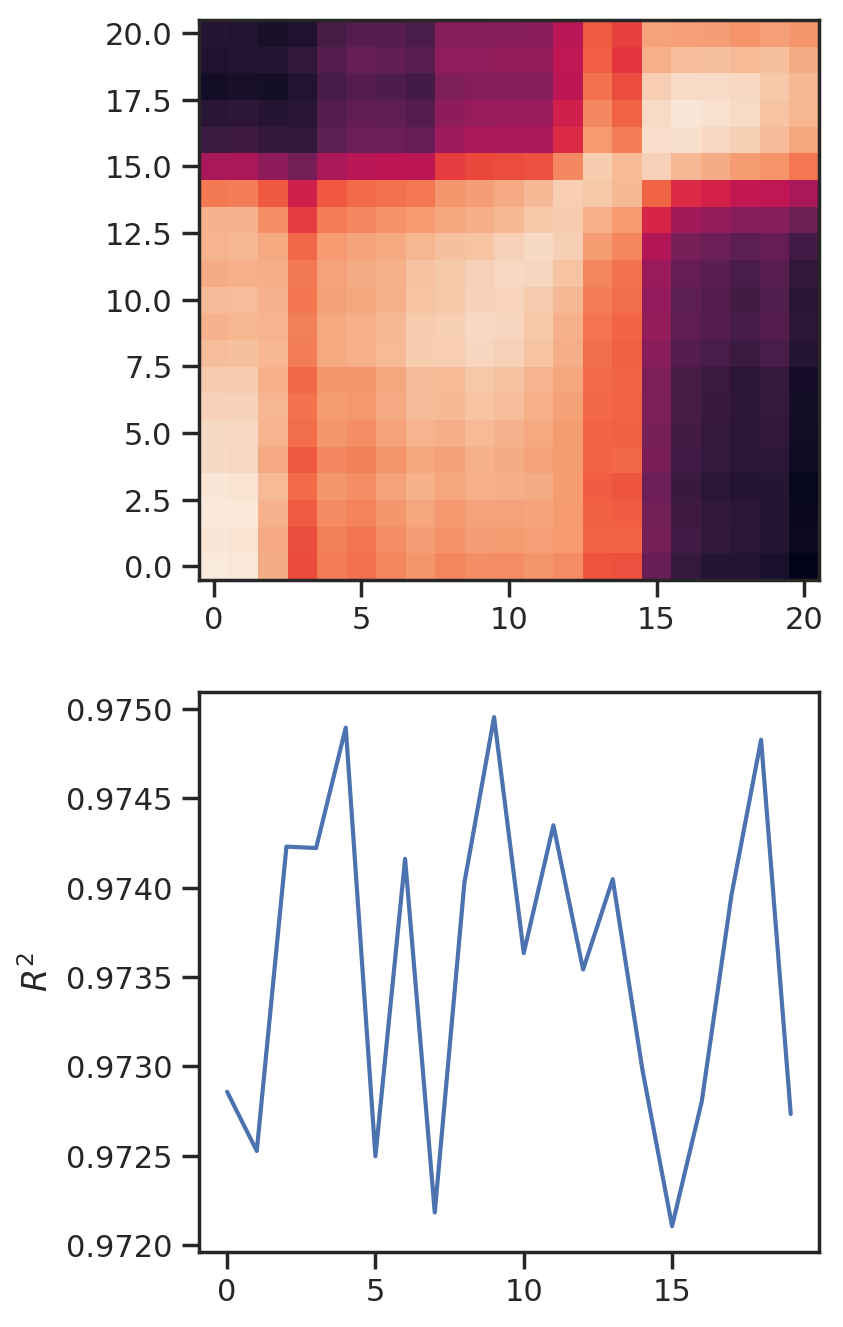

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
x = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/results_latest/cka_T_IllustrisTNG_4_and_48_trials_appliedon_IllustrisTNG_Maps_16examples.npy')
ax[0].imshow(x, origin='lower', aspect='auto')

import glob
l = sorted(glob.glob('internal*_T_IllustrisTNG_IllustrisTNG_*TRIALS_4_48*model1.npy'), key=lambda x: int(x.split('_')[5]))

my_list = []

for f in l:
  r2_rmse = np.load(f)
  r2_omega = r2_rmse[0][0]
  my_list.append(r2_omega)

ax[1].set_ylabel('$R^2$')
ax[1].plot(my_list);

## 2.3 CKA paper approach

Train a one-layer model at the end of every layer and record the accuracy.

This section only stores output. Training is done in another notebook: see [here](https://colab.research.google.com/drive/1f8c5Ut-K4cevVIq7S4QdCEiicg28HyF7?authuser=1#scrollTo=Th9A_xvcVY7L).

In [ ]:
import glob
import os
import numpy as np

base_dir = '/content/drive/MyDrive/CAMELS/After_ICML_results'

In [ ]:
field = 'T'
data_sim = 'SIMBA'
model_sim = 'IllustrisTNG'
trial_1 = 43

study_name = 'wd_dr_hidden_lr_o3'

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 1
lr         = 1e-3
wd         = 0.0005  #value of weight decay
dr         = 0.2    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1
epochs     = 10    #number of epochs to train the network

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else os.path.join(base_dir, f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
print(f'Shape of selected maps array: {maps.shape}')
del maps

# IMPORTANT: shuffle must be False to ensure iteration over train loader is stable.
# We need the iterations to be stable since after saving, the outputs will be used for training.
train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True, shuffle=False)
# valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=True,  verbose=True)
# test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                         rot_flip_in_mem=False, verbose=True, shuffle=False)

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Shape of selected maps array: (1000, 256, 256)
Found 1 channels
Reading data...
(1000, 256, 256) 1000
3.106e+02 < F(all|orig) < 2.002e+11
2.492 < F(all|resc)  < 11.301
-2.121 < F(all|norm) < 8.671


In [ ]:
# import gc
# def get_outputs(model, train_loader, prefix=None):  # index specifies output of which layer we want to extract.
#   model.eval()
#   arr = np.empty(21, object)
#   for i, (x, y) in enumerate(train_loader):
#     with torch.no_grad():
#       bs   = x.shape[0]         #batch size
#       x    = x.to(device)       #maps
#       y    = y.to(device)[:,g]  #parameters

#       out  = model(x)[1]           #NN output
#       arr[:] = out
#       np.save(f'{prefix}_output_batch{i}.npy', arr)
#       del out
#       gc.collect()

import gc
def get_outputs(model, train_loader, prefix=None, layer_index=0):  # index specifies output of which layer we want to extract.
  model.eval()
  for i, (x, y) in enumerate(train_loader):
    with torch.no_grad():
      bs   = x.shape[0]         #batch size
      x    = x.to(device)       #maps
      y    = y.to(device)[:, g]  #parameters

      out  = model(x)           #NN output

      filename = f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/only_single_trial_approach/layer_outputs/{layer_index}/{field}_{model_sim}_{data_sim}_trial{trial_number_1}_batchsize{batch_size}_layerIndex{layer_index}_batchnum{i}.pt'
      if not os.path.exists(filename):
        torch.save(out, filename)
      del out
      gc.collect()

In [ ]:
print(f'Training set size: {len(train_loader.dataset)}')
# print(f'Validation set size: {len(valid_loader.dataset)}')
# print(f'Testing set size: {len(test_loader.dataset)}')

# layer_index = 0

fweights_1 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
fweights_2 = os.path.join(base_dir, f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt')
fdatabase1 = 'sqlite:////' + os.path.join(base_dir, f'{model_sim}_o3_{field}_all_steps_500_500_o3.db')

study = optuna.load_study(study_name=study_name, storage=fdatabase1)

trial_number_1 = int(fweights_1.split('/')[6].split('_')[3])
# trial_number_2 = int(fweights_2.split('/')[6].split('_')[3])

for layer_index in range(3, 21):
# for layer_index in range(3):
  print(f'===> <=== {layer_index} ===> <===')
  models = load_two_models_for_similarity_measure(
      fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_1, fdatabase2=None, layer_output=True, layer_index=layer_index
  )

  get_outputs(models[0], train_loader, layer_index=layer_index)  # Since both models used for CKA are the same, doesn't matter whether models[0] or models[1] is used.

Training set size: 900
===> <=== 3 ===> <===
Assuming same database for the two models...
GPUs not available

Trial number: 43
Trial number:  number 43
Loss:          -1.30537e+01
Params: 
    dr: 0.3987253293774888
    hidden: 11
    lr: 0.003600248836660691
    wd: 0.02580584806198075
total number of parameters in the model = 28436376
Weights loaded

Trial number: 43
Trial number:  number 43
Loss:          -1.30537e+01
Params: 
    dr: 0.3987253293774888
    hidden: 11
    lr: 0.003600248836660691
    wd: 0.02580584806198075
total number of parameters in the model = 28436376
Weights loaded
===> <=== 4 ===> <===
Assuming same database for the two models...
GPUs not available

Trial number: 43
Trial number:  number 43
Loss:          -1.30537e+01
Params: 
    dr: 0.3987253293774888
    hidden: 11
    lr: 0.003600248836660691
    wd: 0.02580584806198075
total number of parameters in the model = 28436376
Weights loaded

Trial number: 43
Trial number:  number 43
Loss:          -1.30537e+01

Exception ignored in: <function _xla_gc_callback at 0x79a2765045e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

**Caution**: You might see that the sum of no. of images in train, validation, and testing set is greater than the no. of maps selected. This is fine since the validation set has rotation set to True, so the validation set is augmented.

In [ ]:
import os
p = '/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/only_single_trial_approach/layer_outputs'
for i in range(21):
  os.mkdir(p + f'/{i}')

## Temp things...Mgas/MF

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_ne_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_ne_SIMBA_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_ne_all_steps_500_500_o3.db
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_ne_all_steps_500_500_o3.db

--2023-08-28 13:25:31--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_ne_IllustrisTNG_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_ne_IllustrisTNG_LH_z=0.00.npy’

Maps_ne_IllustrisTN 100%[===================>]   3.66G  32.6MB/s    in 1m 45s  

2023-08-28 13:27:16 (35.8 MB/s) - ‘Maps_ne_IllustrisTNG_LH_z=0.00.npy’ saved [3932160128/3932160128]

--2023-08-28 13:27:17--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_ne_SIMBA_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.

In [ ]:
field = 'Mgas'
model_sim = 'SIMBA'
study_name = 'wd_dr_hidden_lr_o3'
fdatabase1 = 'sqlite:////content/SIMBA_o3_Mgas_all_steps_500_500_o3.db'

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trials = len(study.trials)

losses = np.zeros(trials)
completed_trials = 0
for i,t in enumerate(study.trials):
  losses[i] = t.value
  if t.value is not None:  completed_trials += 1
print('Number of completed trials: %d'%completed_trials)

# Print info of top two trials.
indexes = np.argsort(losses)
for trial_number in indexes[:2]:
  trial = study.trials[trial_number]
  print("\nTrial number:  number {}".format(trial.number))
  print("Loss:          %.5e"%trial.value)
  print("Params: ")
  for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 54

Trial number:  number 30
Loss:          -1.12345e+01
Params: 
    dr: 0.6947783934276565
    hidden: 9
    lr: 0.0017075040823326846
    wd: 0.04877515999346346

Trial number:  number 53
Loss:          -1.12060e+01
Params: 
    dr: 0.5130212930783267
    hidden: 9
    lr: 0.0006514013419537891
    wd: 0.09183217023548529


In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_Mgas_24_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_Mgas_33_all_steps_500_500_o3.pt

--2023-08-28 13:02:20--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_Mgas_24_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113811518 (109M) [application/octet-stream]
Saving to: ‘weights_IllustrisTNG_Mgas_24_all_steps_500_500_o3.pt’

weights_IllustrisTN 100%[===================>] 108.54M  32.8MB/s    in 3.6s    

2023-08-28 13:02:24 (30.0 MB/s) - ‘weights_IllustrisTNG_Mgas_24_all_steps_500_500_o3.pt’ saved [113811518/113811518]

--2023-08-28 13:02:24--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_Mgas_33_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstit

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_SIMBA.txt

--2023-08-28 13:04:26--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_LH_IllustrisTNG.txt’

params_LH_Illustris 100%[===================>]  46.88K   296KB/s    in 0.2s    

2023-08-28 13:04:26 (296 KB/s) - ‘params_LH_IllustrisTNG.txt’ saved [48000/48000]

--2023-08-28 13:04:26--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_SIMBA.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_Mgas_30_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_Mgas_53_all_steps_500_500_o3.pt

--2023-08-28 13:29:39--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_Mgas_30_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76217136 (73M) [application/octet-stream]
Saving to: ‘weights_SIMBA_Mgas_30_all_steps_500_500_o3.pt’

weights_SIMBA_Mgas_ 100%[===================>]  72.69M  26.9MB/s    in 2.7s    

2023-08-28 13:29:42 (26.9 MB/s) - ‘weights_SIMBA_Mgas_30_all_steps_500_500_o3.pt’ saved [76217136/76217136]

--2023-08-28 13:29:43--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_Mgas_53_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connec

In [ ]:
import shutil

field = 'Mgas'
data_sim = 'IllustrisTNG'
model_sim = 'SIMBA'
study_name = 'wd_dr_hidden_lr_o3'

# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None if data_sim == model_sim else os.path.join(base_dir, f'Maps_{field}_{model_sim}_LH_z=0.00.npy')] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = os.path.join(base_dir, f'params_LH_{data_sim}.txt')
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 1   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = os.path.join(base_dir, f'Maps_{field}_{data_sim}_LH_z=0.00.npy')
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
  if i%15 in np.arange(splits):
    indexes[count] = i
    count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

batch_size = 32
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                        rot_flip_in_mem=False, verbose=True, shuffle=False)

#########################
trial_1 = 30
trial_2 = 53
#########################

cka_filename = f'cka_{field}_{model_sim}_{trial_1}_and_{trial_2}_trials_appliedon_{data_sim}_Maps_{batch_size}examples.npy'

print(f'====== Trials {trial_1} and {trial_2} ======')
fweights_1 = f'weights_{model_sim}_{field}_{trial_1}_all_steps_500_500_o3.pt'
fweights_2 = f'weights_{model_sim}_{field}_{trial_2}_all_steps_500_500_o3.pt'
fdatabase1 = f'sqlite:////content/{model_sim}_o3_{field}_all_steps_500_500_o3.db'

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
trial_number_1 = int(fweights_1.split('_')[3])
trial_number_2 = int(fweights_2.split('_')[3])

models = load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None)

#Get test results
print('Model 1')
params_true, params_NN, errors_NN = get_test_acc(models[0], test_loader)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)
np.save(cka_filename.replace('cka', 'acc_model_1'), np.vstack([r2, rmse]))
# shutil.copy(cka_filename.replace('cka', 'acc_model_1'), os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach'))
print('Model 2')
params_true2, params_NN, errors_NN = get_test_acc(models[1], test_loader)
assert np.all(params_true == params_true2)
r2 = get_r2_score(params_true, params_NN)
rmse = get_rmse(params_true, params_NN)
print(r2)
print(rmse)
np.save(cka_filename.replace('cka', 'acc_model_2'), np.vstack([r2, rmse]))
# shutil.copy(cka_filename.replace('cka', 'acc_model_2'), os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach'))
print("====================")

# print("=====")
# print(params_true)
# print(params_NN)
# print("=====")

# Calculate CKA
data_batch = []
for i, (x, y) in enumerate(test_loader):
  if i == 0:
    data_batch.append(x)
    break
  # if i == 0:
  #   break
x = torch.vstack(data_batch)

with torch.no_grad():
  _, intermediate_outputs_A = models[0](x)
  _, intermediate_outputs_B = models[1](x)
  # sim = compare_activations(models[0], models[1], x)
  # test_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)
  sim = get_CKA(n_layers=21, n_layers2=21, activations1=intermediate_outputs_A, activations2=intermediate_outputs_B)

# Save CKA
np.save(cka_filename, sim)
# shutil.copy(cka_filename, os.path.join(base_dir, 'for_final_paper/only_top_two_trials_approach'))
# shutil.copy(cka_filename.replace('cka', 'acc_model_1'), base_dir+'for_final_paper/')
# shutil.copy(cka_filename.replace('cka', 'acc_model_2'), base_dir+'for_final_paper/')

Shape of the maps: (15000, 256, 256)
Selected 1000 maps out of 15000
Found 1 channels
Reading data...
(1000, 256, 256) 1000
8.615e+08 < F(all|orig) < 1.485e+14
8.935 < F(all|resc)  < 14.172
-3.598 < F(all|norm) < 8.181
====== Trials 30 and 53 ======
Assuming same database for the two models...
GPUs not available

Trial number: 30
Trial number:  number 30
Loss:          -1.12345e+01
Params: 
    dr: 0.6947783934276565
    hidden: 9
    lr: 0.0017075040823326846
    wd: 0.04877515999346346
total number of parameters in the model = 19039800
Weights loaded

Trial number: 53
Trial number:  number 53
Loss:          -1.12060e+01
Params: 
    dr: 0.5130212930783267
    hidden: 9
    lr: 0.0006514013419537891
    wd: 0.09183217023548529
total number of parameters in the model = 19039800
Weights loaded
Model 1

Number of maps in the test set: 50
Test loss = -5.145e+00

[-0.0411897257818743, -1.2869116464704877, -0.40258045770024475, -0.8454226150875295, -1.0227244901368753, -0.5684125039952168]



Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


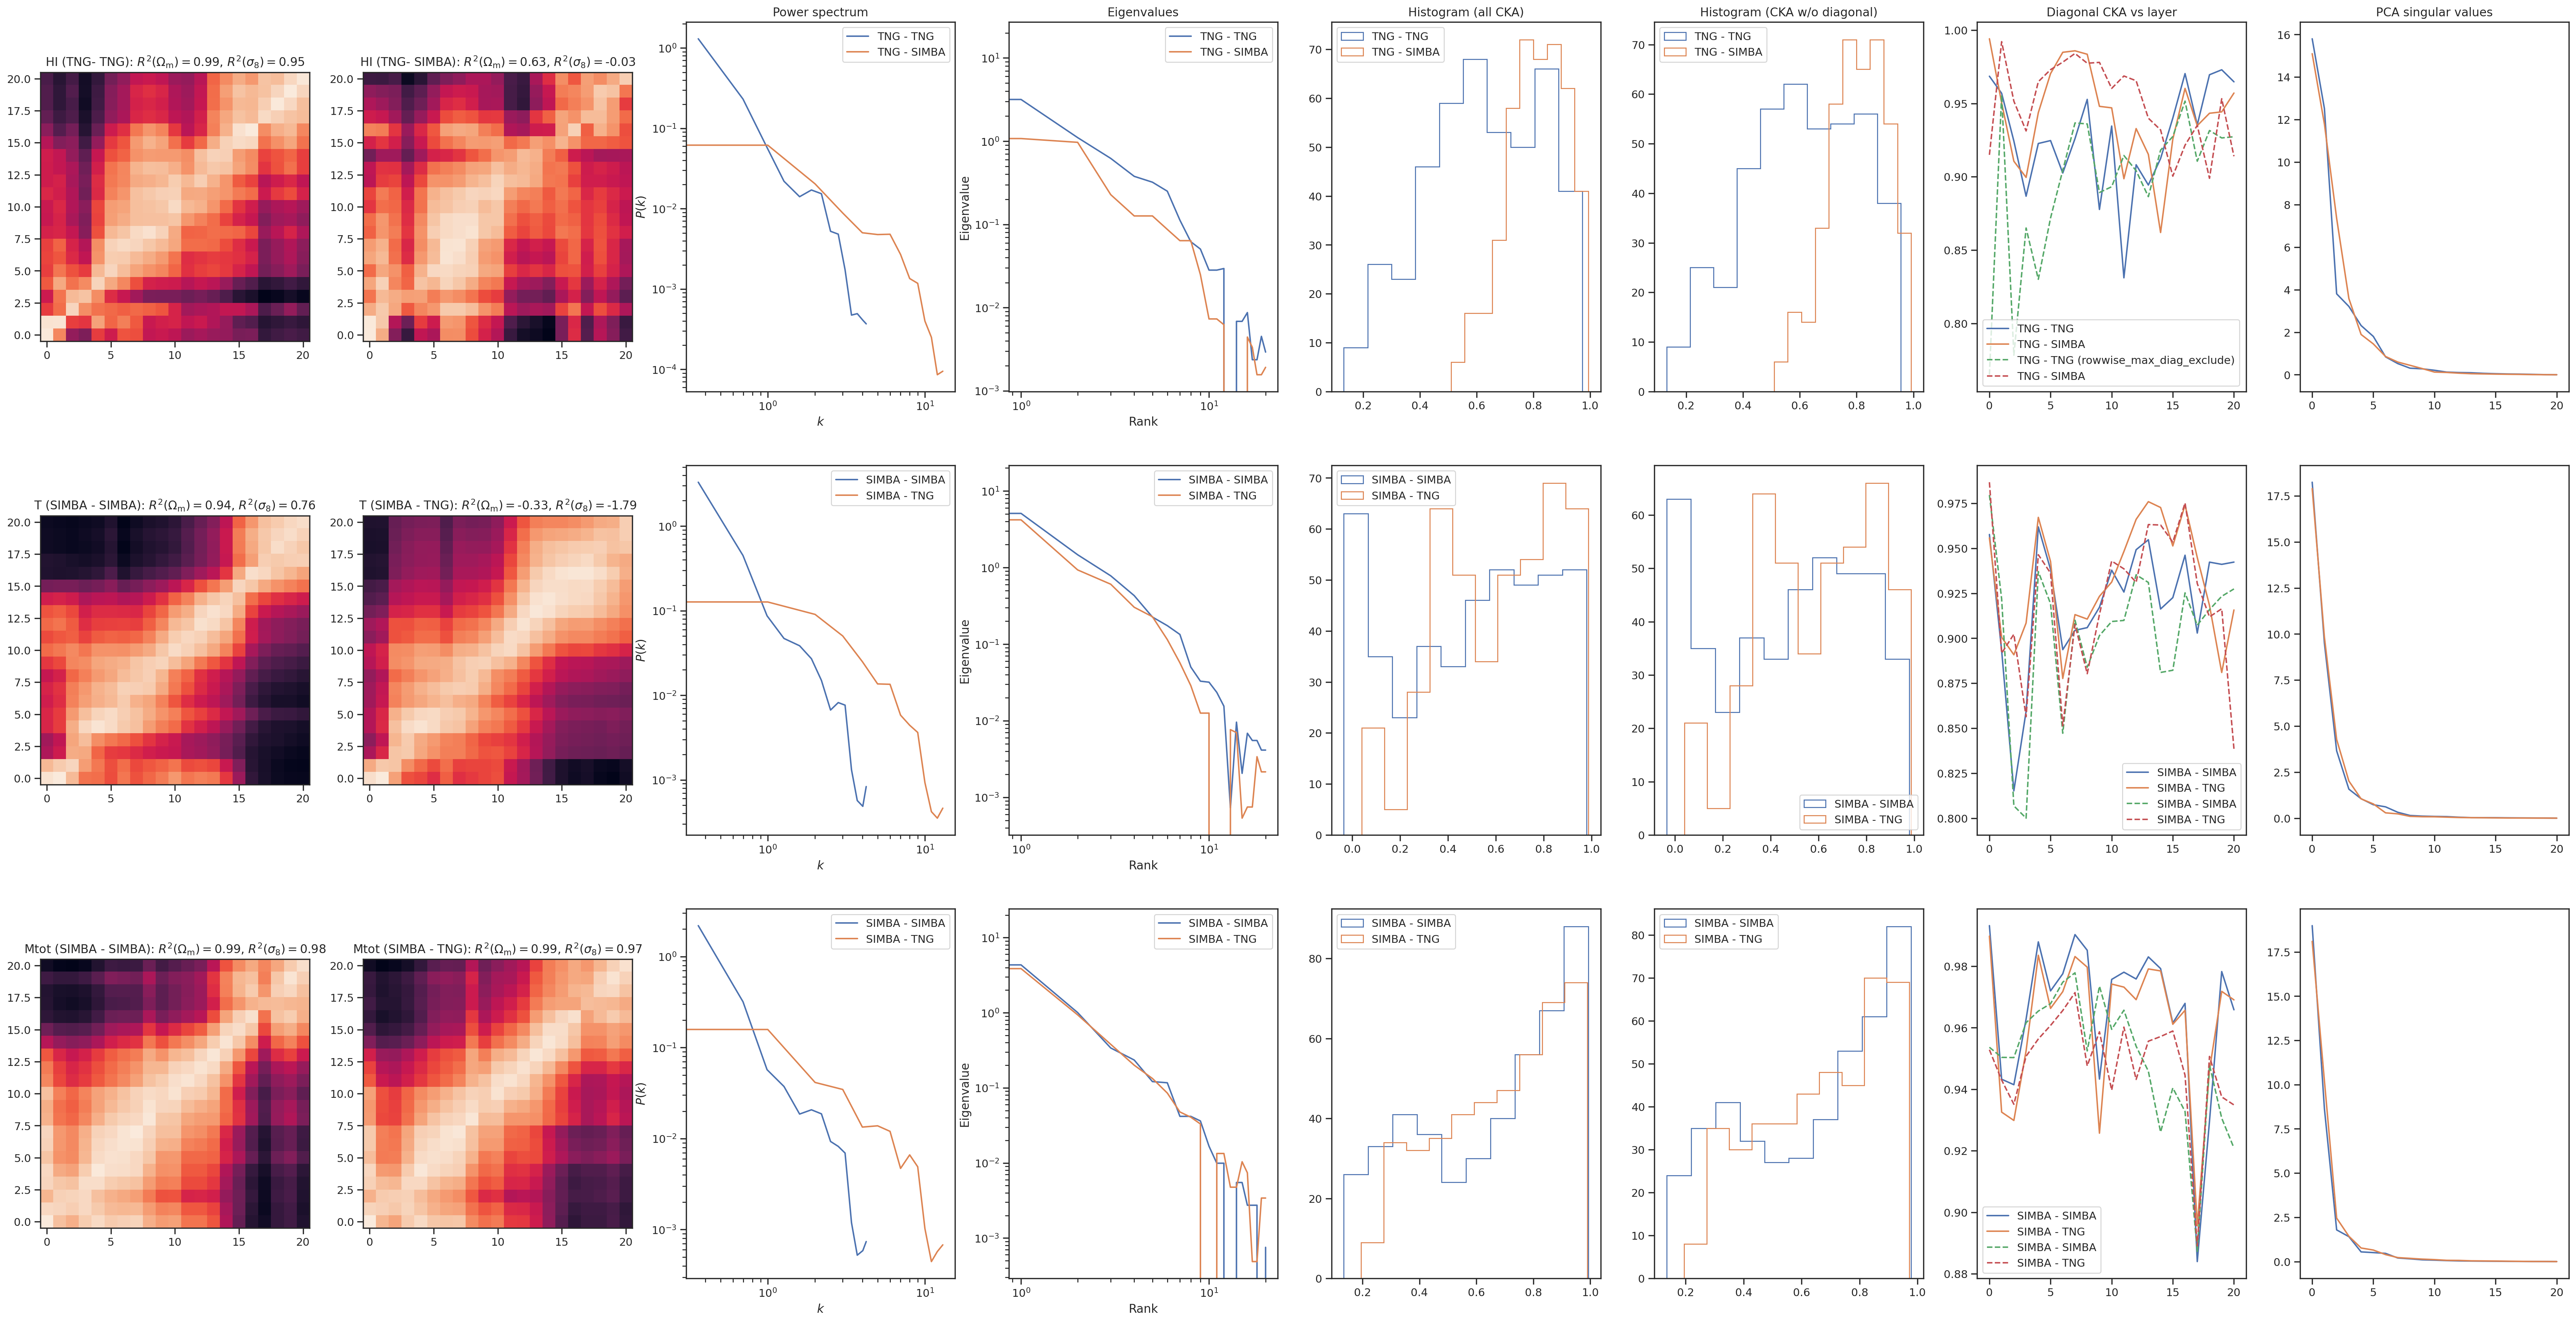

In [ ]:
trial_1_Mtot = 16
trial_2_Mtot = 43
trial_1_HI = 28
trial_2_HI = 31
trial_1_T = 30
trial_2_T = 53

HI_TT_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
HI_TT_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
HI_TT_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

HI_TT_pca = get_pca_components(HI_TT_cka)

# R2 scores
HI_TT_acc_omegam = np.round((HI_TT_acc1[0][0] + HI_TT_acc2[0][0]) / 2, 2)
HI_TT_acc_sigma8 = np.round((HI_TT_acc1[0][1] + HI_TT_acc2[0][1]) / 2, 2)

HI_TS_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')
HI_TS_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')
HI_TS_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_HI_IllustrisTNG_{trial_1_HI}_and_{trial_2_HI}_trials_appliedon_SIMBA_Maps_32examples.npy')

HI_TS_pca = get_pca_components(HI_TS_cka)

HI_TS_acc_omegam = np.round((HI_TS_acc1[0][0] + HI_TS_acc2[0][0]) / 2, 2)
HI_TS_acc_sigma8 = np.round((HI_TS_acc1[0][1] + HI_TS_acc2[0][1]) / 2, 2)

T_SS_cka = np.load(f'/content/cka_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')
T_SS_acc1 = np.load(f'/content/acc_model_1_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')
T_SS_acc2 = np.load(f'/content/acc_model_2_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_SIMBA_Maps_32examples.npy')

T_SS_pca = get_pca_components(T_SS_cka)

T_SS_acc_omegam = np.round((T_SS_acc1[0][0] + T_SS_acc2[0][0]) / 2, 2)
T_SS_acc_sigma8 = np.round((T_SS_acc1[0][1] + T_SS_acc2[0][1]) / 2, 2)

T_ST_cka = np.load(f'/content/cka_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
T_ST_acc1 = np.load(f'/content/acc_model_1_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
T_ST_acc2 = np.load(f'/content/acc_model_2_Mgas_SIMBA_{trial_1_T}_and_{trial_2_T}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

T_ST_pca = get_pca_components(T_ST_cka)

T_ST_acc_omegam = np.round((T_ST_acc1[0][0] + T_ST_acc2[0][0]) / 2, 2)
T_ST_acc_sigma8 = np.round((T_ST_acc1[0][1] + T_ST_acc2[0][1]) / 2, 2)

Mtot_SS_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')
Mtot_SS_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')
Mtot_SS_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_SIMBA_Maps_32examples.npy')

Mtot_SS_pca = get_pca_components(Mtot_SS_cka)

Mtot_SS_acc_omegam = np.round((Mtot_SS_acc1[0][0] + Mtot_SS_acc2[0][0]) / 2, 2)
Mtot_SS_acc_sigma8 = np.round((Mtot_SS_acc1[0][1] + Mtot_SS_acc2[0][1]) / 2, 2)

Mtot_ST_cka = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/cka_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
Mtot_ST_acc1 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_1_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')
Mtot_ST_acc2 = np.load(f'/content/drive/MyDrive/CAMELS/After_ICML_results/for_final_paper/only_top_two_trials_approach/acc_model_2_Mtot_SIMBA_{trial_1_Mtot}_and_{trial_2_Mtot}_trials_appliedon_IllustrisTNG_Maps_32examples.npy')

Mtot_ST_pca = get_pca_components(Mtot_ST_cka)

Mtot_ST_acc_omegam = np.round((Mtot_ST_acc1[0][0] + Mtot_ST_acc2[0][0]) / 2, 2)
Mtot_ST_acc_sigma8 = np.round((Mtot_ST_acc1[0][1] + Mtot_ST_acc2[0][1]) / 2, 2)

HI_TT_pspec = ps_2d(HI_TT_cka)
HI_TS_pspec = ps_2d(HI_TS_cka)
T_SS_pspec = ps_2d(T_SS_cka)
T_ST_pspec = ps_2d(T_ST_cka)
Mtot_SS_pspec = ps_2d(Mtot_SS_cka)
Mtot_ST_pspec = ps_2d(Mtot_ST_cka)

HI_TT_spec = spectra(HI_TT_cka)
HI_TS_spec = spectra(HI_TS_cka)
T_SS_spec = spectra(T_SS_cka)
T_ST_spec = spectra(T_ST_cka)
Mtot_SS_spec = spectra(Mtot_SS_cka)
Mtot_ST_spec = spectra(Mtot_ST_cka)

def row_wise_max_exclude_diagonal(A):
  B = np.copy(A)   # copy A
  B[np.diag_indices_from(B)] = -np.inf  # fill up diagonals with - infty
  return np.max(B,axis = 1) # compute maximum

titles = ['HI (TNG- TNG)', 'HI (TNG- SIMBA)', 'T (SIMBA - SIMBA)', 'T (SIMBA - TNG)', 'Mtot (SIMBA - SIMBA)', 'Mtot (SIMBA - TNG)']

def get_non_diagonal(arr):
  return arr[~np.eye(arr.shape[0],dtype=bool)]

def get_result_string(acc_omegam, acc_sigma8):
  return r'$R^{2}(\Omega_{\rm m})=$' + f'{acc_omegam}, ' + r'$R^{2}(\sigma_8)=$' + f'{acc_sigma8}'

fig, ax = plt.subplots(3, 8, figsize=(46, 23))
ax[0, 0].imshow(HI_TT_cka); ax[0, 1].imshow(HI_TS_cka);
ax[0, 0].set_title(f'{titles[0]}: {get_result_string(HI_TT_acc_omegam, HI_TT_acc_sigma8)}'); ax[0, 1].set_title(f'{titles[1]}: {get_result_string(HI_TS_acc_omegam, HI_TS_acc_sigma8)}')
ax[0, 2].plot(HI_TT_pspec[0], HI_TT_pspec[1], label=f'TNG - TNG'); ax[0, 2].plot(HI_TS_pspec[1], label='TNG - SIMBA');
ax[0, 3].plot(HI_TT_spec, label='TNG - TNG'); ax[0, 3].plot(HI_TS_spec, label='TNG - SIMBA');
ax[0, 4].hist(HI_TT_cka.flatten(), histtype='step', label='TNG - TNG'); ax[0, 4].hist(HI_TS_cka.flatten(), histtype='step', label='TNG - SIMBA')
ax[0, 5].hist(get_non_diagonal(HI_TT_cka).flatten(), histtype='step', label='TNG - TNG'); ax[0, 5].hist(get_non_diagonal(HI_TS_cka).flatten(), histtype='step', label='TNG - SIMBA')
ax[0, 6].plot(np.diag(HI_TT_cka), label='TNG - TNG'); ax[0, 6].plot(np.diag(HI_TS_cka), label='TNG - SIMBA')
ax[0, 6].plot(row_wise_max_exclude_diagonal(HI_TT_cka), label='TNG - TNG (rowwise_max_diag_exclude)', linestyle='dashed'); ax[0, 6].plot(row_wise_max_exclude_diagonal(HI_TS_cka), label='TNG - SIMBA', linestyle='dashed')
ax[0, 7].plot(HI_TT_pca[0], label='TNG - TNG'); ax[0, 7].plot(HI_TS_pca[0], label='TNG - SIMBA')

ax[1, 0].imshow(T_SS_cka); ax[1, 1].imshow(T_ST_cka);
ax[1, 0].set_title(f'{titles[2]}: {get_result_string(T_SS_acc_omegam, T_SS_acc_sigma8)}'); ax[1, 1].set_title(f'{titles[3]}: {get_result_string(T_ST_acc_omegam, T_ST_acc_sigma8)}')
ax[1, 2].plot(T_SS_pspec[0], T_SS_pspec[1], label='SIMBA - SIMBA'); ax[1, 2].plot(T_ST_pspec[1], label='SIMBA - TNG');
ax[1, 3].plot(T_SS_spec, label='SIMBA - SIMBA'); ax[1, 3].plot(T_ST_spec, label='SIMBA - TNG');
ax[1, 4].hist(T_SS_cka.flatten(), histtype='step', label='SIMBA - SIMBA'); ax[1, 4].hist(T_ST_cka.flatten(), histtype='step', label='SIMBA - TNG')
ax[1, 5].hist(get_non_diagonal(T_SS_cka).flatten(), histtype='step', label='SIMBA - SIMBA'); ax[1, 5].hist(get_non_diagonal(T_ST_cka).flatten(), histtype='step', label='SIMBA - TNG')
ax[1, 6].plot(np.diag(T_SS_cka), label='SIMBA - SIMBA'); ax[1, 6].plot(np.diag(T_ST_cka), label='SIMBA - TNG')
ax[1, 6].plot(row_wise_max_exclude_diagonal(T_SS_cka), label='SIMBA - SIMBA', linestyle='dashed'); ax[1, 6].plot(row_wise_max_exclude_diagonal(T_ST_cka), label='SIMBA - TNG', linestyle='dashed')
ax[1, 7].plot(T_SS_pca[0], label='SIMBA - SIMBA'); ax[1, 7].plot(T_ST_pca[0], label='SIMBA - TNG')

ax[2, 0].imshow(Mtot_SS_cka); ax[2, 1].imshow(Mtot_ST_cka);
ax[2, 0].set_title(f'{titles[4]}: {get_result_string(Mtot_SS_acc_omegam, Mtot_SS_acc_sigma8)}'); ax[2, 1].set_title(f'{titles[5]}: {get_result_string(Mtot_ST_acc_omegam, Mtot_ST_acc_sigma8)}')
ax[2, 2].plot(Mtot_SS_pspec[0], Mtot_SS_pspec[1], label='SIMBA - SIMBA'); ax[2, 2].plot(Mtot_ST_pspec[1], label='SIMBA - TNG');
ax[2, 3].plot(Mtot_SS_spec, label='SIMBA - SIMBA'); ax[2, 3].plot(Mtot_ST_spec, label='SIMBA - TNG');
ax[2, 4].hist(Mtot_SS_cka.flatten(), histtype='step', label='SIMBA - SIMBA'); ax[2, 4].hist(Mtot_ST_cka.flatten(), histtype='step', label='SIMBA - TNG')
ax[2, 5].hist(get_non_diagonal(Mtot_SS_cka).flatten(), histtype='step', label='SIMBA - SIMBA'); ax[2, 5].hist(get_non_diagonal(Mtot_ST_cka).flatten(), histtype='step', label='SIMBA - TNG')
ax[2, 6].plot(np.diag(Mtot_SS_cka), label='SIMBA - SIMBA'); ax[2, 6].plot(np.diag(Mtot_ST_cka), label='SIMBA - TNG')
ax[2, 6].plot(row_wise_max_exclude_diagonal(Mtot_SS_cka), label='SIMBA - SIMBA', linestyle='dashed'); ax[2, 6].plot(row_wise_max_exclude_diagonal(Mtot_ST_cka), label='SIMBA - TNG', linestyle='dashed')
ax[2, 7].plot(Mtot_SS_pca[0], label='SIMBA - SIMBA'); ax[2, 7].plot(Mtot_ST_pca[0], label='SIMBA - TNG')

ax[0, 2].legend(); ax[0, 3].legend(); ax[0, 4].legend(), ax[0, 5].legend(); ax[0, 6].legend()
ax[1, 2].legend(); ax[1, 3].legend(); ax[1, 4].legend(), ax[1, 5].legend(); ax[1, 6].legend()
ax[2, 2].legend(); ax[2, 3].legend(); ax[2, 4].legend(), ax[2, 5].legend(); ax[2, 6].legend()

ax[0, 2].set_title('Power spectrum')
ax[0, 3].set_title('Eigenvalues')
ax[0, 4].set_title('Histogram (all CKA)')
ax[0, 5].set_title('Histogram (CKA w/o diagonal)')
ax[0, 6].set_title('Diagonal CKA vs layer')
ax[0, 7].set_title('PCA singular values')

for i in range(3):
  for j in range(2):
    ax[i, j].axes.invert_yaxis()

for i in range(3):
  for j in [2, 3]:
    ax[i, j].set_xscale('log'); ax[i, j].set_yscale('log')

for i in range(3):
  ax[i, 2].set_ylabel(r'$P(k)$'); ax[i, 2].set_xlabel(r'$k$')
  ax[i, 3].set_ylabel('Eigenvalue'); ax[i, 3].set_xlabel('Rank')

# jj = 0
# for i in range(3):
#   for j in range(2):
#     ax[i, j].set_title(titles[jj])
#     jj += 1

# plt.tight_layout()

# Plots

In [3]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_SIMBA_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_SIMBA_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_SIMBA_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_CV_IllustrisTNG.txt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_CV_SIMBA.txt

--2023-11-27 05:34:22--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_CV_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106168448 (101M) [application/octet-stream]
Saving to: ‘Maps_T_IllustrisTNG_CV_z=0.00.npy’

Maps_T_IllustrisTNG 100%[===================>] 101.25M   124MB/s    in 0.8s    

2023-11-27 05:34:23 (124 MB/s) - ‘Maps_T_IllustrisTNG_CV_z=0.00.npy’ saved [106168448/106168448]

--2023-11-27 05:34:23--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_SIMBA_CV_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.4

In [4]:
# import numpy as np
# pm = np.loadtxt(f'/content/drive/MyDrive/CAMELS/After_ICML_results/params_LH_IllustrisTNG.txt')
# params_map = pm[100//15]
# print(params_map)

# pm = np.loadtxt(f'/content/drive/MyDrive/CAMELS/After_ICML_results/params_LH_SIMBA.txt')
# params_map = pm[100//15]
# print(params_map)

index = 10

import numpy as np
pm = np.loadtxt(f'/content/params_CV_IllustrisTNG.txt')
params_map = pm[index//15]
print(params_map)

pm = np.loadtxt(f'/content/params_CV_SIMBA.txt')
params_map = pm[index//15]
print(params_map)

[0.3 0.8 1.  1.  1.  1. ]
[0.3 0.8 1.  1.  1.  1. ]


In [5]:
# mtng = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy', mmap_mode='r')
# msimba = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_Mtot_SIMBA_LH_z=0.00.npy', mmap_mode='r')
# mtot_tng = mtng[100]
# mtot_simba = msimba[100]

# del mtng, msimba

# ttng = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_T_IllustrisTNG_LH_z=0.00.npy', mmap_mode='r')
# tsimba = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_T_SIMBA_LH_z=0.00.npy', mmap_mode='r')
# t_tng = ttng[100]
# t_simba = tsimba[100]

# del ttng, tsimba

# hitng = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_HI_IllustrisTNG_LH_z=0.00.npy', mmap_mode='r')
# hisimba = np.load('/content/drive/MyDrive/CAMELS/After_ICML_results/Maps_HI_SIMBA_LH_z=0.00.npy', mmap_mode='r')
# hi_tng = hitng[100]
# hi_simba = hisimba[100]

# del hitng, hisimba

mtng = np.load('/content/Maps_Mtot_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
msimba = np.load('/content/Maps_Mtot_SIMBA_CV_z=0.00.npy', mmap_mode='r')
mtot_tng = mtng[index]
mtot_simba = msimba[index]

del mtng, msimba

ttng = np.load('/content/Maps_T_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
tsimba = np.load('/content/Maps_T_SIMBA_CV_z=0.00.npy', mmap_mode='r')
t_tng = ttng[index]
t_simba = tsimba[index]

del ttng, tsimba

hitng = np.load('/content/Maps_HI_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
hisimba = np.load('/content/Maps_HI_SIMBA_CV_z=0.00.npy', mmap_mode='r')
hi_tng = hitng[index]
hi_simba = hisimba[index]

del hitng, hisimba

In [11]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mcdm_SIMBA_CV_z=0.00.npy

mcdm_tng = np.load('/content/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
mcdm_simba = np.load('/content/Maps_Mcdm_SIMBA_CV_z=0.00.npy', mmap_mode='r')

--2023-11-27 05:42:00--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106168448 (101M) [application/octet-stream]
Saving to: ‘Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy’

Maps_Mcdm_Illustris 100%[===================>] 101.25M   122MB/s    in 0.8s    

2023-11-27 05:42:01 (122 MB/s) - ‘Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy’ saved [106168448/106168448]

--2023-11-27 05:42:01--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mcdm_SIMBA_CV_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|

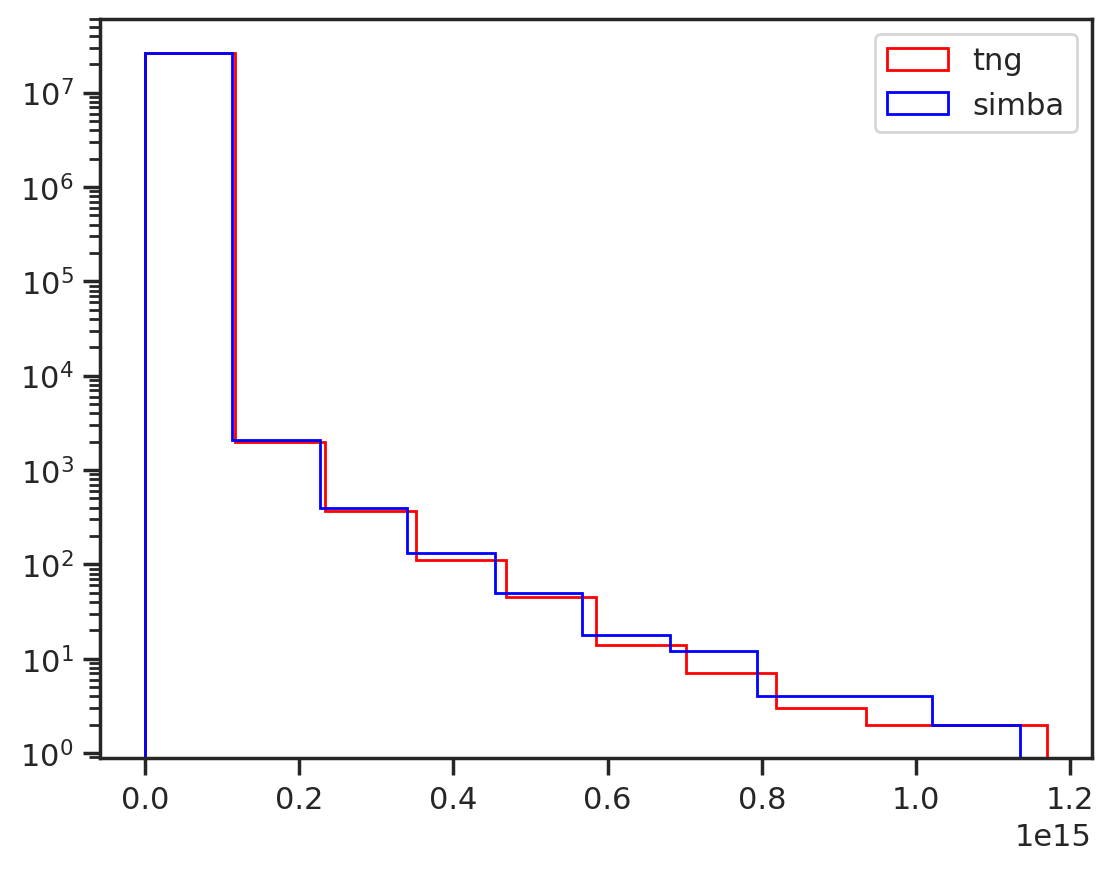

In [13]:
mtng = np.load('/content/Maps_Mcdm_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
msimba = np.load('/content/Maps_Mcdm_SIMBA_CV_z=0.00.npy', mmap_mode='r')

plt.hist(mcdm_tng.flatten(), color='red', label='tng', histtype='step')
plt.hist(mcdm_simba.flatten(), color='blue', label='simba', histtype='step')
plt.legend()
plt.yscale('log')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rc('text', usetex=False)

import seaborn as sns
sns.set_context("paper", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')

color1 = '#FC9272'
color2 = '#1C9099'

titlesize = 20
axeslabelsize = 18
ticklabelsize = 18

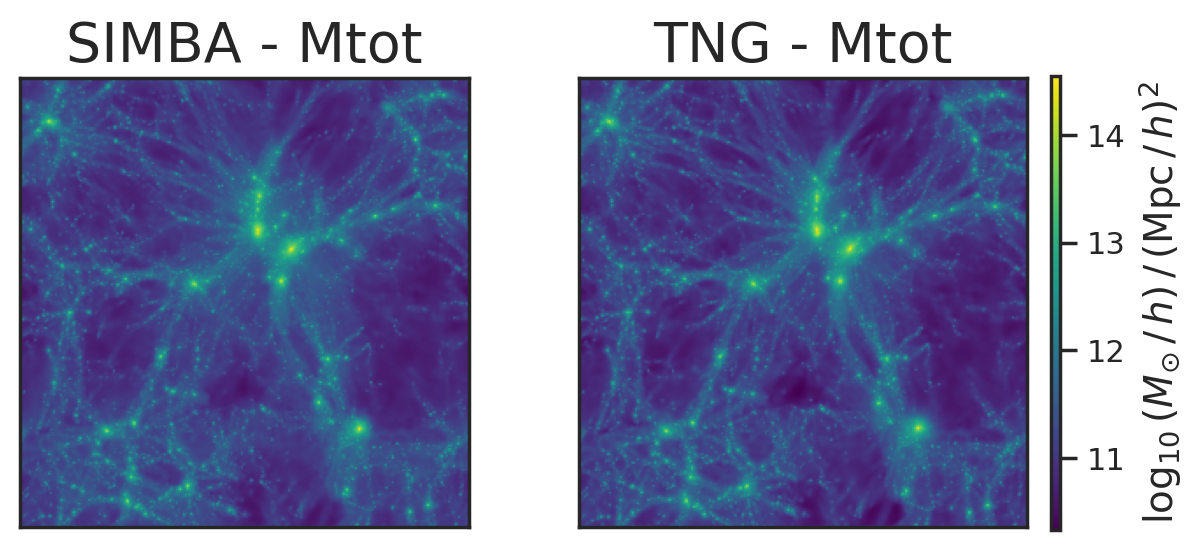

In [53]:
def log(x):
  return np.log10(x)

import matplotlib.pyplot as plt
min_mtot, max_mtot = np.min([log(mtot_tng), log(mtot_simba)]), np.max([log(mtot_tng), log(mtot_simba)])
min_t, max_t = np.min([log(t_tng), log(t_simba)]), np.max([log(t_tng), log(t_simba)])
min_hi, max_hi = np.min([log(hi_tng), log(hi_simba)]), np.max([log(hi_tng), log(hi_simba)])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 4.5))
ax[0].imshow(log(mtot_simba), cmap='viridis', vmin=min_mtot, vmax=max_mtot, origin='lower')
im1 = ax[1].imshow(log(mtot_tng), cmap='viridis', vmin=min_mtot, vmax=max_mtot, origin='lower')

fig.subplots_adjust(wspace=0.245)
cbar_ax = fig.add_axes([0.918, 0.2425, 0.007, 0.505])
cbar1 = fig.colorbar(im1, cax=cbar_ax, orientation="vertical")
cbar1.set_label(r'$\log_{10}(M_{\odot} \, / \, h) \, / \, (\mathrm{Mpc} \, / \, h)^2$', fontsize=14)

cbar1.set_ticks([11,12,13,14])
cbar1.set_ticklabels([11,12,13,14])

for a in ax:
  a.set_xticks([])
  a.set_yticks([])

ax[0].set_title('SIMBA - Mtot', fontsize=titlesize)
ax[1].set_title('TNG - Mtot', fontsize=titlesize)

# fig, ax = plt.subplots(2, 3, figsize=(8, 5))
# im00 = ax[0, 0].imshow(log(mtot_tng), cmap='gray', vmin=min_mtot, vmax=max_mtot)
# im01 = ax[0, 1].imshow(log(hi_tng), cmap='viridis', vmin=min_hi, vmax=max_hi)
# im02 = ax[0, 2].imshow(log(t_tng), cmap='plasma', vmin=min_t, vmax=max_t)
# im10 = ax[1, 0].imshow(log(mtot_simba), cmap='gray', vmin=min_mtot, vmax=max_mtot)
# im11 = ax[1, 1].imshow(log(hi_simba), cmap='viridis', vmin=min_hi, vmax=max_hi)
# im12 = ax[1, 2].imshow(log(t_simba), cmap='plasma', vmin=min_t, vmax=max_t)

# ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([])
# ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([])
# ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([])

# ax[1, 0].set_xticks([]); ax[1, 0].set_yticks([])
# ax[1, 1].set_xticks([]); ax[1, 1].set_yticks([])
# ax[1, 2].set_xticks([]); ax[1, 2].set_yticks([])

# ax[0, 0].set_title('TNG - Mtot', fontsize=titlesize)
# ax[0, 1].set_title('TNG - HI', fontsize=titlesize)
# ax[0, 2].set_title('TNG - Temp', fontsize=titlesize)
# ax[1, 0].set_title('SIMBA - Mtot', fontsize=titlesize)
# ax[1, 1].set_title('SIMBA - HI', fontsize=titlesize)
# ax[1, 2].set_title('SIMBA - Temp', fontsize=titlesize)

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.13, 0.06, 0.22, 0.02])
# cbar1 = fig.colorbar(im10, cax=cbar_ax, orientation="horizontal")
# cbar1.set_label(r'$\log_{10}(M_{\odot} \, / \, h) \, / \, (\mathrm{Mpc} \, / \, h)^2$')

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.402, 0.06, 0.22, 0.02])
# cbar2 = fig.colorbar(im11, cax=cbar_ax, orientation="horizontal")
# cbar2.set_label(r'$\log_{10}(M_{\odot} \, / \, h) \, / \, (\mathrm{Mpc} \, / \, h)^2$')

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.675, 0.06, 0.22, 0.02])
# cbar3 = fig.colorbar(im12, cax=cbar_ax, orientation="horizontal")
# cbar3.set_label("Kelvin")

# # ax[0, 0].set_title(r'$N$-body' + r' $(\Omega_{\rm m}$' + ' = ' + f'{Nbody_params[0]:.2f},' + fr' $\sigma_8$ = {Nbody_params[1]:.2f})', fontsize=13)
# # ax[0].set_title('HI - TNG' + r' $(\Omega_{\rm m}$' + ' = ' + f'{HI_tng_params[0]:.2f},' + fr' $\sigma_8$ = {HI_tng_params[1]:.2f})', fontsize=13)
# # ax[1].set_title('Temp - TNG' + r' $(\Omega_{\rm m}$' + ' = ' + f'{T_tng_params[0]:.2f},' + fr' $\sigma_8$ = {T_tng_params[1]:.2f})', fontsize=13)
# # ax[2].set_title('HI - SIMBA' + r' $(\Omega_{\rm m}$' + ' = ' + f'{HI_simba_params[0]:.2f},' + fr' $\sigma_8$ = {HI_simba_params[1]:.2f})', fontsize=13)
# # ax[3].set_title('Temp - SIMBA' + r' $(\Omega_{\rm m}$' + ' = ' + f'{T_simba_params[0]:.2f},' + fr' $\sigma_8$ = {T_simba_params[1]:.2f})', fontsize=13)

# # divider = make_axes_locatable(ax[0, 0])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im00, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[0, 1])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im01, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[0, 2])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im02, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[1, 1])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im11, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[1, 2])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im12, cax=cax, orientation='vertical')

# # plt.tight_layout()
plt.savefig('mtot_maps.png', bbox_inches='tight', dpi=250)

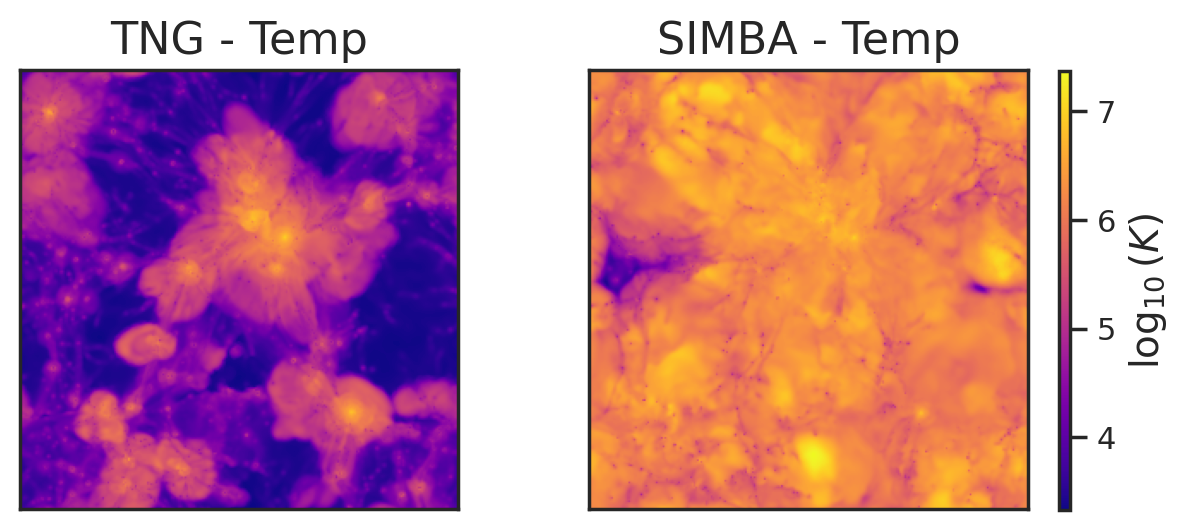

In [97]:
def log(x):
  return np.log10(x)

import matplotlib.pyplot as plt
min_mtot, max_mtot = np.min([log(mtot_tng), log(mtot_simba)]), np.max([log(mtot_tng), log(mtot_simba)])
min_t, max_t = np.min([log(t_tng), log(t_simba)]), np.max([log(t_tng), log(t_simba)])
min_hi, max_hi = np.min([log(hi_tng), log(hi_simba)]), np.max([log(hi_tng), log(hi_simba)])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 4.5))
ax[0].imshow(log(t_tng), cmap='plasma', vmin=min_t, vmax=max_t, origin='lower')
im1 = ax[1].imshow(log(t_simba), cmap='plasma', vmin=min_t, vmax=max_t, origin='lower')

fig.subplots_adjust(wspace=0.3)
cbar_ax = fig.add_axes([0.924, 0.25, 0.009, 0.488])
cbar1 = fig.colorbar(im1, cax=cbar_ax, orientation="vertical")
cbar1.set_label(r'$\log_{10}(K)$', fontsize=14)

cbar1.set_ticks([4,5,6,7])
cbar1.set_ticklabels([4,5,6,7])

for a in ax:
  a.set_xticks([])
  a.set_yticks([])

ax[0].set_title('TNG - Temp', fontsize=titlesize-4)
ax[1].set_title('SIMBA - Temp', fontsize=titlesize-4)

# fig, ax = plt.subplots(2, 3, figsize=(8, 5))
# im00 = ax[0, 0].imshow(log(mtot_tng), cmap='gray', vmin=min_mtot, vmax=max_mtot)
# im01 = ax[0, 1].imshow(log(hi_tng), cmap='viridis', vmin=min_hi, vmax=max_hi)
# im02 = ax[0, 2].imshow(log(t_tng), cmap='plasma', vmin=min_t, vmax=max_t)
# im10 = ax[1, 0].imshow(log(mtot_simba), cmap='gray', vmin=min_mtot, vmax=max_mtot)
# im11 = ax[1, 1].imshow(log(hi_simba), cmap='viridis', vmin=min_hi, vmax=max_hi)
# im12 = ax[1, 2].imshow(log(t_simba), cmap='plasma', vmin=min_t, vmax=max_t)

# ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([])
# ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([])
# ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([])

# ax[1, 0].set_xticks([]); ax[1, 0].set_yticks([])
# ax[1, 1].set_xticks([]); ax[1, 1].set_yticks([])
# ax[1, 2].set_xticks([]); ax[1, 2].set_yticks([])

# ax[0, 0].set_title('TNG - Mtot', fontsize=titlesize)
# ax[0, 1].set_title('TNG - HI', fontsize=titlesize)
# ax[0, 2].set_title('TNG - Temp', fontsize=titlesize)
# ax[1, 0].set_title('SIMBA - Mtot', fontsize=titlesize)
# ax[1, 1].set_title('SIMBA - HI', fontsize=titlesize)
# ax[1, 2].set_title('SIMBA - Temp', fontsize=titlesize)

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.13, 0.06, 0.22, 0.02])
# cbar1 = fig.colorbar(im10, cax=cbar_ax, orientation="horizontal")
# cbar1.set_label(r'$\log_{10}(M_{\odot} \, / \, h) \, / \, (\mathrm{Mpc} \, / \, h)^2$')

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.402, 0.06, 0.22, 0.02])
# cbar2 = fig.colorbar(im11, cax=cbar_ax, orientation="horizontal")
# cbar2.set_label(r'$\log_{10}(M_{\odot} \, / \, h) \, / \, (\mathrm{Mpc} \, / \, h)^2$')

# fig.subplots_adjust()
# cbar_ax = fig.add_axes([0.675, 0.06, 0.22, 0.02])
# cbar3 = fig.colorbar(im12, cax=cbar_ax, orientation="horizontal")
# cbar3.set_label("Kelvin")

# # ax[0, 0].set_title(r'$N$-body' + r' $(\Omega_{\rm m}$' + ' = ' + f'{Nbody_params[0]:.2f},' + fr' $\sigma_8$ = {Nbody_params[1]:.2f})', fontsize=13)
# # ax[0].set_title('HI - TNG' + r' $(\Omega_{\rm m}$' + ' = ' + f'{HI_tng_params[0]:.2f},' + fr' $\sigma_8$ = {HI_tng_params[1]:.2f})', fontsize=13)
# # ax[1].set_title('Temp - TNG' + r' $(\Omega_{\rm m}$' + ' = ' + f'{T_tng_params[0]:.2f},' + fr' $\sigma_8$ = {T_tng_params[1]:.2f})', fontsize=13)
# # ax[2].set_title('HI - SIMBA' + r' $(\Omega_{\rm m}$' + ' = ' + f'{HI_simba_params[0]:.2f},' + fr' $\sigma_8$ = {HI_simba_params[1]:.2f})', fontsize=13)
# # ax[3].set_title('Temp - SIMBA' + r' $(\Omega_{\rm m}$' + ' = ' + f'{T_simba_params[0]:.2f},' + fr' $\sigma_8$ = {T_simba_params[1]:.2f})', fontsize=13)

# # divider = make_axes_locatable(ax[0, 0])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im00, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[0, 1])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im01, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[0, 2])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im02, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[1, 1])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im11, cax=cax, orientation='vertical')

# # divider = make_axes_locatable(ax[1, 2])
# # cax = divider.append_axes('right', size='5%', pad=0.05)
# # fig.colorbar(im12, cax=cax, orientation='vertical')

# # plt.tight_layout()
plt.savefig('temperature_1.png', dpi=250)

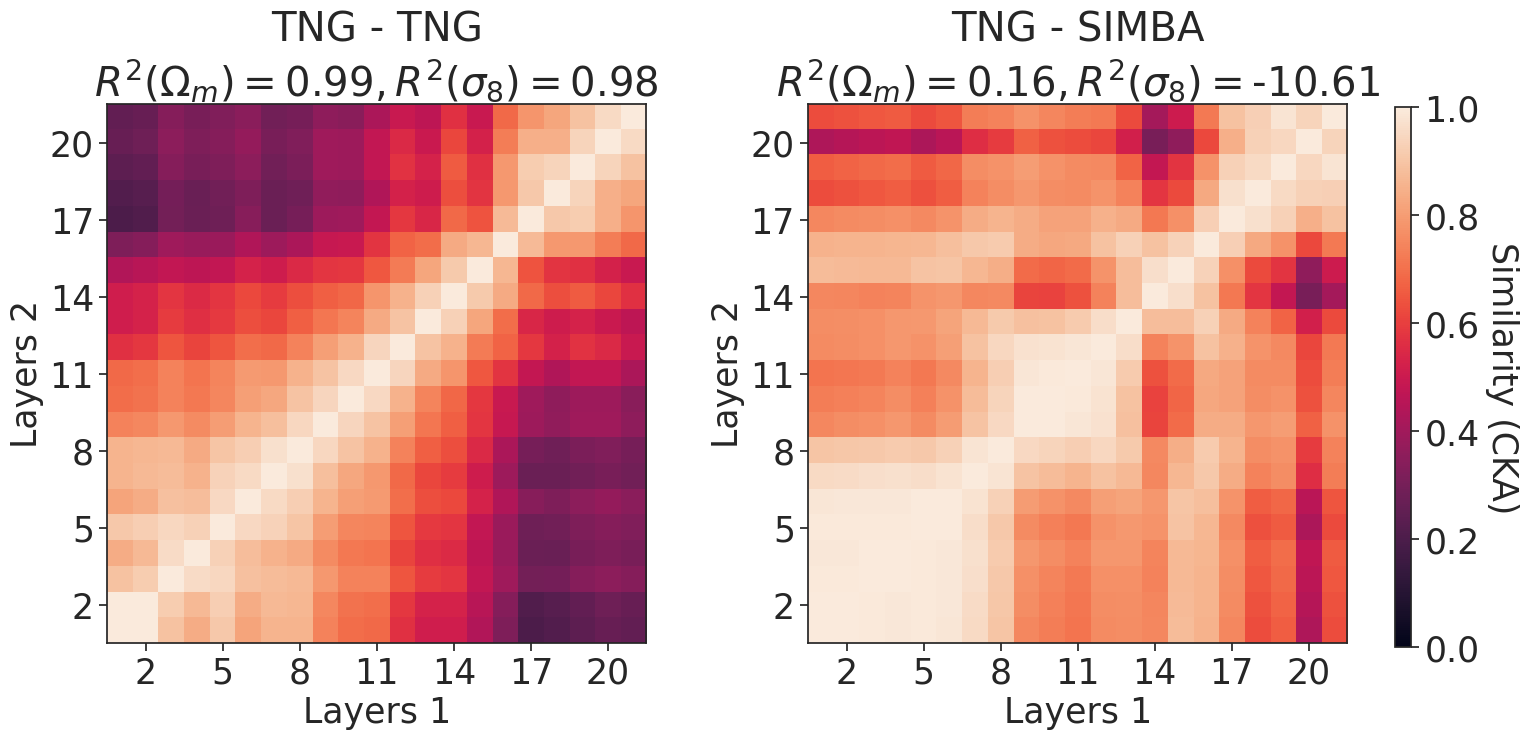

In [9]:
import seaborn as sns
sns.set_context("paper", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')
# sns.set_palette(
#     sns.color_palette("YlOrRd")
# )
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('tableau-colorblind10')

import numpy as np

t_tt = np.load('/content/cka_T_IllustrisTNG_43_and_43_trials_appliedon_IllustrisTNG_Maps_50examples.npy')
t_ts = np.load('/content/cka_T_IllustrisTNG_43_and_43_trials_appliedon_SIMBA_Maps_50examples.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 9))

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.2)

ax[0].imshow(t_tt, vmin=0, vmax=1)
im = ax[1].imshow(t_ts, vmin=0, vmax=1)

ax[0].set_title('TNG - TNG\n'+r'$R^2(\Omega_m) = 0.99, R^2(\sigma_8) = 0.98$', fontsize=titlesize+9)
ax[1].set_title('TNG - SIMBA\n'+r'$R^2(\Omega_m) = 0.16, R^2(\sigma_8) = $-$10.61$', fontsize=titlesize+9)

fig.subplots_adjust(wspace=0.3)
cbar_ax = fig.add_axes([0.93, 0.191, 0.01, 0.6])
cbar1 = fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar1.ax.tick_params(labelsize=ticklabelsize+7)
cbar1.ax.set_ylabel('Similarity (CKA)', rotation=270, fontsize=ticklabelsize+7, labelpad=28)


for i, a in enumerate(ax):
  a.axes.invert_yaxis()
  a.set_xticks(range(1, 22, 3))
  a.set_xticklabels(range(2, 23, 3), fontsize=ticklabelsize+7)
  a.set_yticks(range(1, 22, 3))
  a.set_yticklabels(range(2, 23, 3), fontsize=ticklabelsize+7)
  a.set_xlabel('Layers 1', fontsize=ticklabelsize+7)
  #if i != 1:
  a.set_ylabel('Layers 2', fontsize=ticklabelsize+7)
# plt.tight_layout()
plt.savefig('temperature_2.png', bbox_inches='tight', dpi=250)

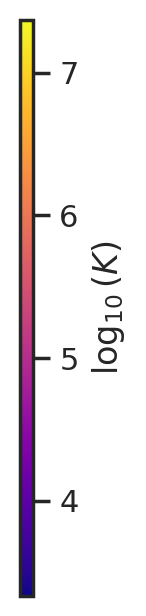

In [ ]:
fig, ax = plt.subplots(1, 1)

im = ax.imshow(t_tng, cmap='plasma', vmin=min_t, vmax=max_t)

cbar_ax = fig.add_axes([0.01, 0.01, 0.01, 0.6])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
cbar3=fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar3.set_label(r"$\log_{10}(K)$")

cbar3.set_ticks([4,5,6,7])
cbar3.set_ticklabels([4,5,6,7])

ax.remove()
plt.savefig('cbar_temp.png',bbox_inches='tight', dpi=200)

In [ ]:
min(mtng.min(), msimba.min()), max(mtng.max(), msimba.max())

(7758330000.0, 1302427000000000.0)

## Poster plots

In [ ]:
import seaborn as sns
sns.set_context("poster", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')

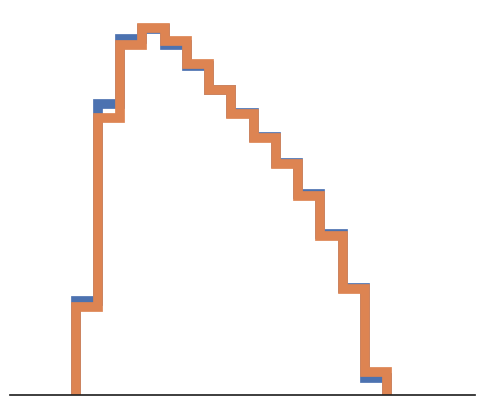

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mtng = np.load('/content/Maps_Mtot_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
msimba = np.load('/content/Maps_Mtot_SIMBA_CV_z=0.00.npy', mmap_mode='r')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.hist(mtng.ravel(), bins=np.logspace(8.7, 16.7, 20), label='TNG', histtype='step', linewidth=7);
ax.hist(msimba.ravel(), bins=np.logspace(8.7, 16.7, 20), label='SIMBA', histtype='step', linewidth=7);
# ax.legend(loc='upper right')
# ax.legend_.get_frame().set_facecolor('#deebf7')
# ax.legend_.get_frame().set_edgecolor('#deebf7')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.minorticks_off()

plt.savefig('mtot_dist.png', bbox_inches='tight', transparent=True, dpi=250)

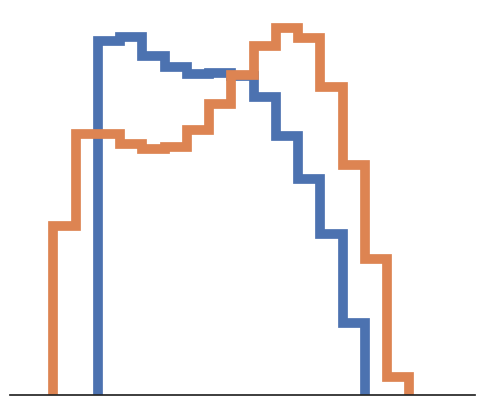

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mtng = np.load('/content/Maps_T_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
msimba = np.load('/content/Maps_T_SIMBA_CV_z=0.00.npy', mmap_mode='r')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.hist(mtng.ravel(), bins=np.logspace(2, 9, 20), label='TNG', histtype='step', linewidth=7);
ax.hist(msimba.ravel(), bins=np.logspace(2, 9, 20), label='SIMBA', histtype='step', linewidth=7);
# ax.legend(loc='lower center')
# ax.legend_.get_frame().set_facecolor('#deebf7')
# ax.legend_.get_frame().set_edgecolor('#deebf7')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.minorticks_off()

plt.savefig('temp_dist.png', bbox_inches='tight', transparent=True, dpi=250)

In [ ]:
min(mtng.min(), msimba.min()), max(mtng.max(), msimba.max())

(360.1801, 124726590.0)

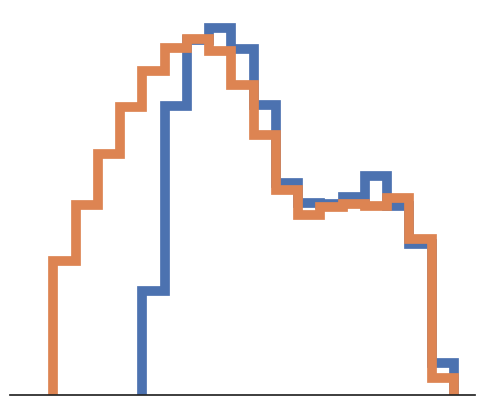

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mtng = np.load('/content/Maps_HI_IllustrisTNG_CV_z=0.00.npy', mmap_mode='r')
msimba = np.load('/content/Maps_HI_SIMBA_CV_z=0.00.npy', mmap_mode='r')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.hist(mtng.ravel(), bins=np.logspace(-2, 13, 20), label='TNG', histtype='step', linewidth=7);
ax.hist(msimba.ravel(), bins=np.logspace(-2, 13, 20), label='SIMBA', histtype='step', linewidth=7);
# ax.legend(loc='upper right')
# ax.legend_.get_frame().set_facecolor('#deebf7')
# ax.legend_.get_frame().set_edgecolor('#deebf7')

ax.set_yscale('log'); ax.set_xscale('log')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.minorticks_off()

plt.savefig('hi_dist.png', bbox_inches='tight', transparent=True, dpi=250)

In [ ]:
min(mtng.min(), msimba.min()), max(mtng.max(), msimba.max())

(0.07326907, 6018072300000.0)

<ipython-input-76-3043234c425c>:6: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  figlegend.legend(lines, ('TNG', 'SIMBA'), 'center')


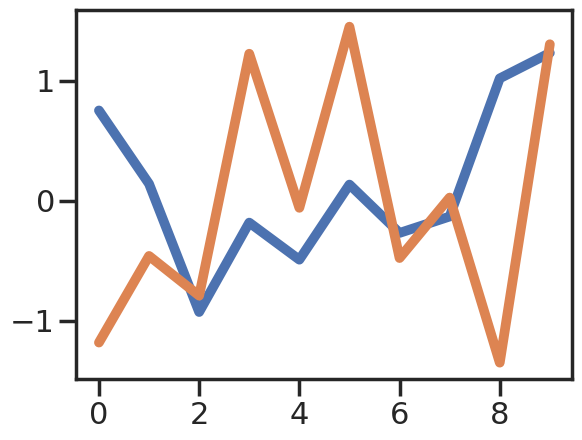

<Figure size 300x200 with 0 Axes>

In [ ]:
import pylab
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10), linewidth=7)
figlegend.legend(lines, ('TNG', 'SIMBA'), 'center')
figlegend.legends[0].get_frame().set_facecolor('#deebf7')
figlegend.legends[0].get_frame().set_edgecolor('#deebf7')
fig.show()
figlegend.show()
figlegend.savefig('legend.png', bbox_inches='tight', transparent=True, dpi=150)

In [ ]:
!unzip ALL_CKA.zip

In [ ]:
from scipy.ndimage.filters import gaussian_filter

<ipython-input-22-e812a2f58216>:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
np.arange(1, 22, 3), np.arange(0, 21, 3)

(array([ 1,  4,  7, 10, 13, 16, 19]), array([ 0,  3,  6,  9, 12, 15, 18]))

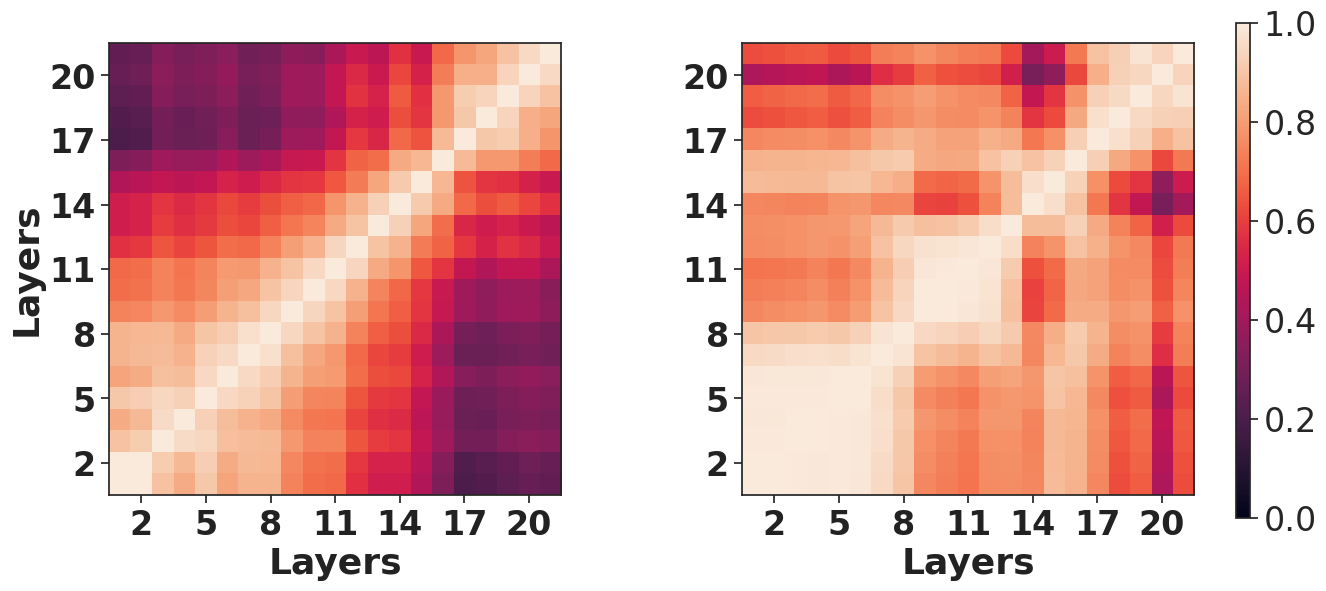

In [ ]:
import seaborn as sns
sns.set_context("poster", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')
# sns.set_palette(
#     sns.color_palette("YlOrRd")
# )
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('tableau-colorblind10')

import numpy as np

t_tt = np.load('/content/cka_T_IllustrisTNG_43_and_43_trials_appliedon_IllustrisTNG_Maps_50examples.npy')
t_ts = np.load('/content/cka_T_IllustrisTNG_43_and_43_trials_appliedon_SIMBA_Maps_50examples.npy')

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.2)

ax[0].imshow(t_tt, vmin=0, vmax=1)
im = ax[1].imshow(t_ts, vmin=0, vmax=1)

fig.subplots_adjust(wspace=0.4)
cbar_ax = fig.add_axes([0.93, 0.14, 0.01, 0.707])
cbar1 = fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar1.ax.tick_params(labelsize=24)

for i, a in enumerate(ax):
  a.axes.invert_yaxis()
  a.set_xticks(range(1, 22, 3))
  a.set_xticklabels(range(2, 23, 3), fontsize=24, weight=600, c='#222222')
  a.set_yticks(range(1, 22, 3))
  a.set_yticklabels(range(2, 23, 3), fontsize=24, weight=600, c='#222222')
  a.set_xlabel('Layers', fontsize=26, weight=600, c='#222222')
  if i != 1:
    a.set_ylabel('Layers', fontsize=26, weight=600, c='#222222')

# plt.tight_layout()
plt.savefig('temp_poster.png', bbox_inches='tight', transparent=True, dpi=300)

In [ ]:
acc_t_tt = np.load('/content/acc_model_1_T_IllustrisTNG_43_and_43_trials_appliedon_IllustrisTNG_Maps_50examples.npy')
acc_t_ts = np.load('/content/acc_model_1_T_IllustrisTNG_43_and_43_trials_appliedon_SIMBA_Maps_50examples.npy')

acc_t_tt[0],acc_t_ts[0]

(array([0.99018373, 0.97452499, 0.69665716, 0.0105609 , 0.93792918,
        0.4713222 ]),
 array([  0.16603222, -10.65921288,  -0.1893944 ,  -0.20873023,
         -0.31323602,  -2.34562789]))

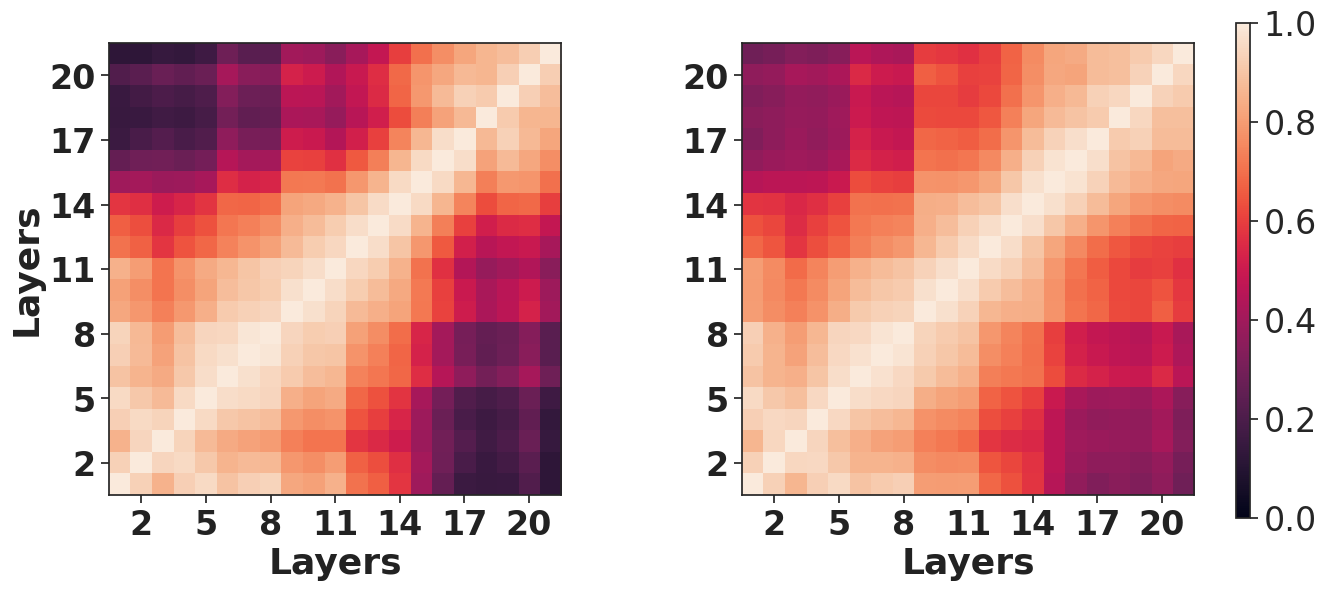

In [ ]:
import seaborn as sns
sns.set_context("poster", font_scale = 2)
sns.set_style('whitegrid')
sns.set(style='ticks')
# sns.set_palette(
#     sns.color_palette("YlOrRd")
# )
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('tableau-colorblind10')

import numpy as np

t_tt = np.load('/content/cka_Mtot_SIMBA_16_and_16_trials_appliedon_SIMBA_Maps_50examples.npy')
t_ts = np.load('/content/cka_Mtot_SIMBA_16_and_16_trials_appliedon_IllustrisTNG_Maps_50examples.npy')

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes('right', size='5%', pad=0.2)

ax[0].imshow(t_tt, vmin=0, vmax=1)
im = ax[1].imshow(t_ts, vmin=0, vmax=1)

fig.subplots_adjust(wspace=0.4)
cbar_ax = fig.add_axes([0.93, 0.14, 0.01, 0.707])
cbar1 = fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar1.ax.tick_params(labelsize=24)

for i, a in enumerate(ax):
  a.axes.invert_yaxis()
  a.set_xticks(range(1, 22, 3))
  a.set_xticklabels(range(2, 23, 3), fontsize=24, weight=600, c='#222222')
  a.set_yticks(range(1, 22, 3))
  a.set_yticklabels(range(2, 23, 3), fontsize=24, weight=600, c='#222222')
  a.set_xlabel('Layers', fontsize=26, weight=600, c='#222222')
  if i != 1:
    a.set_ylabel('Layers', fontsize=26, weight=600, c='#222222')

# plt.tight_layout()
plt.savefig('mtot_poster.png', bbox_inches='tight', transparent=True, dpi=300)